# This script calculates both the suitability change risk and the risk from two extreme events: tropical cyclones and droughts

In [1]:
from pathlib import Path
import sys

# --- Use cwd when __file__ isn't available (Jupyter/IPython) ---
this_dir = Path().resolve()        # current working directory
parent_dir = this_dir.parent
sys.path.insert(0, str(parent_dir))

# ✅ Now this works
from utils_agroforestry import *


# Agroforestry Exposure Builder

This following cell builds **exposure datasets** for agroforestry system modelling from Excel input files.

## Workflow

1. **Import utilities**  
   - Adds the parent directory to `sys.path` so `config.py` and other shared modules can be found.  
   - Imports functions from `utils_agroforestry.py` (e.g. `get_target_species`, `build_exposures_from_file`).  

2. **Load input Excel files**  
   - Looks for all `.xlsx` files inside the `agroforestry_systems/` directory (relative to the notebook/script location).  
   - Each file represents one agroforestry system definition.  

3. **Standardise species names**  
   - Uses a mapping (`species_replacements`) to replace generic entries like `"Inga spp."` with target species such as `"Inga vera"`.  

4. **Build target species list**  
   - Extracts a global list of all relevant species across the input files.  

5. **Generate exposures**  
   - For each Excel file, calls `build_exposures_from_file` to construct an exposure object aligned to the global target species.  
   - Stores all exposures in a dictionary (`exposures_all`) keyed by system name.  





In [2]:
from pathlib import Path

# --- Paths for Excel files ---
notebook_dir = Path().resolve()
excel_dir =  parent_dir / "agroforestry_systems"
excel_files = sorted(excel_dir.glob("*.xlsx"))

# --- Species replacements ---
species_replacements = {
    "Inga spp.": "Inga vera",
    "Citrus spp.": "Citrus sinensis",
    "Quercus spp.": "Quercus sapotifolia",
    "Musa spp.": "Musa acuminata",
    "Chamedorea spp.": "Chamedorea tepejilote",
}

# --- Build global target list ---
target_species = get_target_species(excel_files, species_replacements)

# --- Build exposures for all files ---
exposures_all = {}
for file_path in excel_files:
    parts = file_path.stem.split("__")
    key = "__".join(parts[1:]) if len(parts) >= 3 else file_path.stem
    exposures_all[key] = build_exposures_from_file(
        file_path, target_species, species_replacements
    )

print(f"✅ Created exposures for {len(exposures_all)} files.")


✅ Created exposures for 5 files.


In [3]:
excel_files

[PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250819__Cacao__AltaVerapaz.xlsx'),
 PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250819__Cacao__DR_Cibao_Noroeste.xlsx'),
 PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250819__Coffee__DR_Cibao_Noroeste.xlsx'),
 PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250819__Coffee__Veracruz.xlsx'),
 PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250819__Coffee__WesternHighlands.xlsx'),
 PosixPath('/Users/szelie/python_projects/biofincas_climate_risk/agroforestry_systems/20250826__Cacao__DR_Cibao_Noroeste.xlsx')]

### let's limit a bit the number of alternatives

In [4]:
def filter_exposures(exposures_all):
    """Keep only selected alternatives for each system."""
    keep = {"present", "shade_-20", "shade_+20", "coffee_to_cacao", "cacao_to_coffee"}
    filtered = {}
    for system, alt_dict in exposures_all.items():
        filtered[system] = {k: v for k, v in alt_dict.items() if k in keep}
    return filtered

# ✅ Apply filter
exposures = filter_exposures(exposures_all)

# load impact functions

when we trained the suitability models, we got thresholds for each species that optimise the preformance of the model to have as many false postives as false negatives. We use those threshold, so for instance if the threshold is 0.2, below 0.2 suitability the impact is 100 percent

In [5]:
# Standard assumed densities for main crops in agroforestry systems (trees/ha)
MAIN_CROP_DENSITIES = {
    "Coffea arabica": 1800,   # Coffee (agroforestry average)
    "Theobroma cacao": 1100,  # Cacao (agroforestry average)
}

# Loop through all systems and alternatives
for system_name, alternatives in exposures.items():
    for alt_name, exp in alternatives.items():
        gdf = exp.gdf

        for sci_name, std_density in MAIN_CROP_DENSITIES.items():
            mask = gdf["Scientific name"].str.lower() == sci_name.lower()
            if mask.any():
                gdf.loc[mask, "Plants/ha"] = std_density
                gdf.loc[mask, "value"] = std_density
                print(f"🌱 Set {sci_name} density = {std_density} "
                      f"for {system_name} – {alt_name} ({mask.sum()} rows)")


🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – present (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – shade_-20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – shade_+20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Cacao__AltaVerapaz – cacao_to_coffee (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – present (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – shade_-20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – shade_+20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Cacao__DR_Cibao_Noroeste – cacao_to_coffee (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – present (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – shade_-20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – shade_+20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Coffee__DR_

In [6]:
import numpy as np
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

# Build the set
impf_set = ImpactFuncSet()
for species in target_species:
    impf_set.append(make_threshold_impf(species, impf_id=2, zero=False))  # real (thresholded)
    impf_set.append(make_threshold_impf(species, impf_id=1, zero=True))   # dummy (always 0)


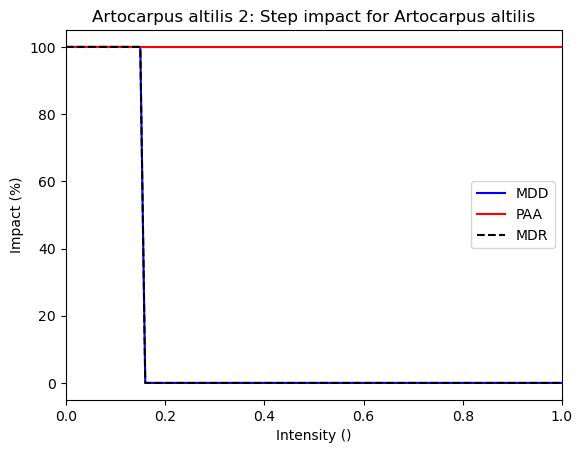

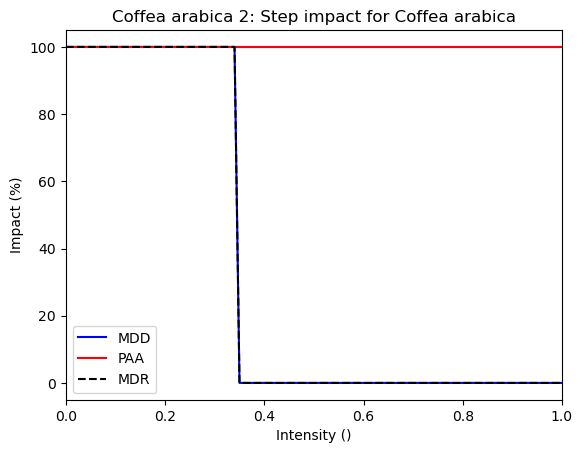

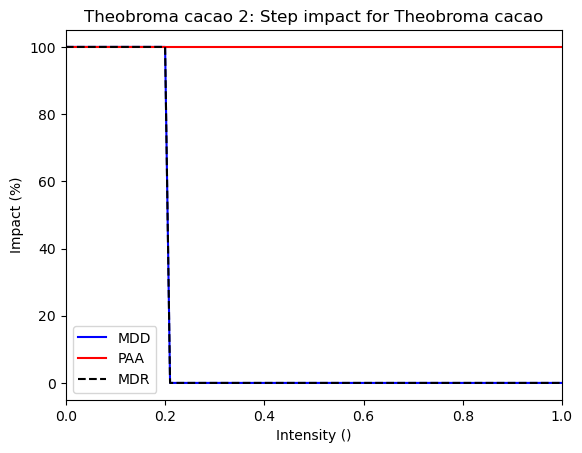

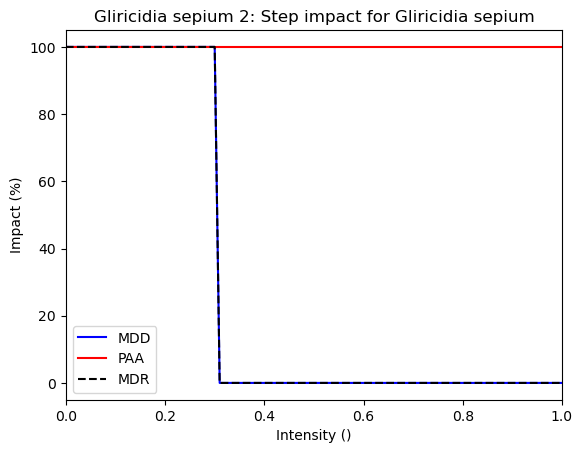

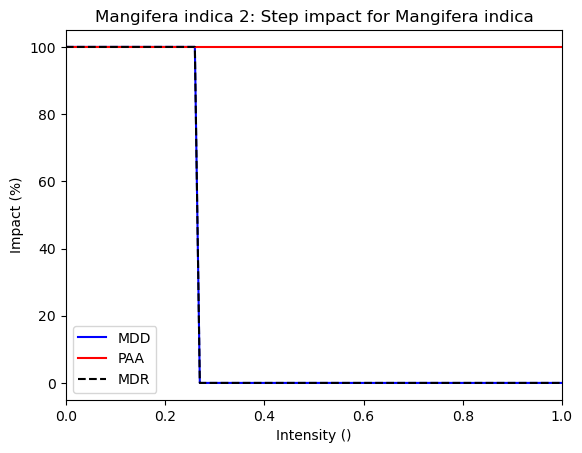

In [7]:
species_list = [
    "Artocarpus altilis",
    "Coffea arabica",
    "Theobroma cacao",
    "Gliricidia sepium",
    "Mangifera indica"
]
for s in species_list:
    impf_set.get_func()[s][2].plot()


# Suitability Maps as Hazard Objects

This script converts species suitability maps into **CLIMADA Hazard objects**.  
The purpose is to represent species suitability (under current and future climate conditions) in the same format that CLIMADA normally uses for hazards (e.g. floods, cyclones, heatwaves).  
This allows us to combine suitability with **exposures** and **impact functions** in a consistent modelling workflow.  

---

## 📘 Workflow

### 1. Load suitability maps
- Function `load_suitability_dict(label)` loads `.parquet` files of suitability values for each species.  

- Each parquet file contains:
- `lon`, `lat`: grid coordinates  
- `suitability`: suitability score for that species at that location  

The function returns a dictionary:
```python
{"Coffea arabica": DataFrame, "Inga vera": DataFrame, ...}
````

### 2. Rebuild spatial grid

* For each species, longitude and latitude are extracted and converted into a 2D grid.
* Suitability values are mapped into this grid (`Z_mean`).
* Missing locations are left as `NaN`.

### 3. Wrap as Hazard

* Suitability is stored in a CLIMADA `Hazard` object using `Hazard.from_xarray_raster`.
* Dimensions:

  * **event**: fixed to a single dummy event (`0`), since suitability is not time-varying.
  * **latitude, longitude**: spatial grid.
  * **time**: dummy timestamp (`2000-01-01`).

⚠️ **Important:**

* A typical hazard (e.g. a flood) has **many events** across time and space.
* These suitability hazards have **only one event**: the static mean suitability under a given climate condition (`now`, `future`, or `4c`).

Each hazard is named like:

```
species_label  →  e.g. "Coffea arabica_now", "Inga vera_future"
```

### 4. Store hazards

* Hazards are stored in a dictionary structure:

```python
hazards = {
  "now": {"Coffea arabica": Hazard, "Inga vera": Hazard, ...},
  "future": {...}
}
```

Species without suitability maps in both **now** and **future** are skipped (listed at the end).

---

## ▶️ Example Output

```text
✅ Created suitability mean Hazard objects.
⚠️ Skipped 2 species (no suitability file):
   - Citrus sinensis
   - Musa acuminata
```

---

## 🌳 How this fits in the pipeline

```text
Suitability map (static scores)
        ↓
Converted to Hazard object (1 dummy event)
        ↓
Exposures (plots, species composition)
        ↓
Dummy Impact Functions (just a matching tool)
        ↓
CLIMADA Impact calculation
```

* Here, suitability plays the role of the "hazard intensity".
* Exposures are the agroforestry plots and their species.
* Dummy impact functions simply act as a bridge, ensuring the species in exposures can be linked with the suitability hazard.

---



In [8]:
from utils_hazards import *
import glob

In [9]:
files = glob.glob(str(DATA_DIR / "suitability" / "*.parquet"))

# --- keep function unchanged ---
hazards = load_suitability_hazards(files, sample=False)



# Suitability Impact Calculation

This script calculates **species-specific suitability scores** for multiple systems based on exposure, hazard, and impact modelling with [CLIMADA](https://climada-python.readthedocs.io/). It loops over available systems and species, evaluates current and future suitability, and stores the results in a structured dictionary of `GeoDataFrame`s.

---

## 📂 Workflow

1. **Inputs**
   - `exposures_present`: dictionary of `Exposures` objects, one per system.
   - `hazards`: dictionary containing hazard objects for `"now"` and `"future"` scenarios, keyed by species.
   - `impf_set`: impact function set compatible with the exposures and hazards.
   - `skipped_species`: list of species to ignore (e.g. missing hazard data).

2. **Processing**
   - For each system in `exposures_present`:
     - Iterate over all species present in the system.
     - Skip species listed in `skipped_species`.
     - Extract hazards (`now` and `future`) for that species.
     - Run CLIMADA `Impact` calculations for both hazard periods.
     - Derive suitability as:

       ```
       suitability = 1 - eai_exp
       ```

       where `eai_exp` is the expected annual impact from CLIMADA.
     - Append results into a per-system list.

3. **Outputs**
   - Results for each system are concatenated into a single `GeoDataFrame` containing:
     - All exposure geometry and attributes,
     - Suitability under `now` and `future` climate scenarios.
   - Stored in a dictionary:

     ```python
     system_results[system_name] = GeoDataFrame(...)
     ```

4. **Final message**
   - The script prints how many systems were successfully processed.

---

## 📑 Data structure of output

Each system’s results are stored as a `GeoDataFrame` with at least the following columns:

- `species_clean`: Original species name from exposures.
- `suitability_now`: Suitability score under current hazard data (0–1).
- `suitability_future`: Suitability score under future hazard data (0–1).
- Additional attributes from the exposure input (location, system metadata, etc.).

---

## ▶️ Example usage

```python
# Example: access results for one system
results = system_results["System_A"]

# Check first rows
print(results.head())

# Plot suitability for current climate
results.plot(column="suitability_now", legend=True)


In [10]:
import pandas as pd
from geopandas import GeoDataFrame
from climada.engine import Impact
from climada.entity import Exposures

# Dictionary to store results per system + alternative
system_results = {}

for system_name, alternatives in exposures.items():
    print(f"📂 Processing system: {system_name}")
    system_results[system_name] = {}

    for alt_name, exp_system in alternatives.items():
        print(f"  🔀 Alternative: {alt_name}")
        results_list = []

        for species in exp_system.gdf.species_clean.unique():
            # 🔹 Only keep rows for this species
            exp_species = exp_system.gdf[exp_system.gdf.species_clean == species].copy()
            exp_species["value"] = exp_species["Plants/ha"]

            # Hazards
            haz_now = hazards["historical"][species]
            haz_future2 = hazards["2c"][species]
            haz_future4 = hazards["4c"][species]

            haz_now.check()
            haz_future2.check()
            haz_future4.check()

            # Impacts
            imp_now = Impact(); imp_now.calc(Exposures(exp_species), impf_set, haz_now)
            imp_2c  = Impact(); imp_2c.calc(Exposures(exp_species), impf_set, haz_future2)
            imp_4c  = Impact(); imp_4c.calc(Exposures(exp_species), impf_set, haz_future4)

            # Build results frame
            df = exp_species.copy()
            df["species_eval"] = species
            df["impact_now"] = imp_now.eai_exp
            df["impact_2c"]  = imp_2c.eai_exp
            df["impact_4c"]  = imp_4c.eai_exp

            # --- Normalise to per-tree loss ---
            df["frac_loss_now"] = df["impact_now"] / df["Plants/ha"]
            df["frac_loss_2c"]  = df["impact_2c"]  / df["Plants/ha"]
            df["frac_loss_4c"]  = df["impact_4c"]  / df["Plants/ha"]


            results_list.append(df)

        if results_list:
            results_all = pd.concat(results_list, ignore_index=True)
            system_results[system_name][alt_name] = GeoDataFrame(
                results_all, crs=exp_system.gdf.crs
            )
        else:
            print(f"  ⚠️ No results for {system_name} – {alt_name} (all species skipped)")

print(f"✅ Created suitability results for {sum(len(v) for v in system_results.values())} system-alternatives.")


📂 Processing system: Cacao__AltaVerapaz
  🔀 Alternative: present
2025-08-26 15:52:02,642 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-26 15:52:02,726 - climada.hazard.base - WARNING - Impact function id=2 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-26 15:52:02,728 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-26 15:52:02,801 - climada.hazard.base - WARNING - Impact function id=2 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-26 15:52:02,804 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-26 15:52:02,873 - climada.hazard.base - WARNING - Impact function id=2 has mdr

# let's also try to build an optimised plot, with species that are less vulnerable to see what impacts this has on th risk

In [11]:
import numpy as np
MAIN_CROPS = ["Coffea arabica", "Theobroma cacao"]
# --- Add "present_optimised" alternatives ---
for system_name, alternatives in system_results.items():
    if "present" not in alternatives:
        continue

    gdf = alternatives["present"].copy()

    # Worst = species with max total impact_2c
    worst_species = (
        gdf[~gdf["Scientific name"].isin(MAIN_CROPS)][['impact_2c', 'Species']]
        .groupby('Species')
        .sum()['impact_2c']
        .idxmax()
    )

    # Best = species with min total impact_2c
    best_species = (
        gdf[~gdf["Scientific name"].isin(MAIN_CROPS)][['impact_2c', 'Species']]
        .groupby('Species')
        .sum()['impact_2c']
        .idxmin()
    )

    # How many trees to reallocate (half of worst species total)
    total_worst = gdf.loc[gdf.Species == worst_species, "Plants/ha"].sum()
    n_shift = int(total_worst * 0.5)

    if n_shift > 0:
        # Subtract from worst species (proportional across rows)
        worst_mask = gdf.Species == worst_species
        gdf.loc[worst_mask, "Plants/ha"] = (
            gdf.loc[worst_mask, "Plants/ha"]
            - (gdf.loc[worst_mask, "Plants/ha"] / total_worst * n_shift).round()
        )

        # Add to best species (proportional across rows if present)
        best_mask = gdf.Species == best_species
        total_best = gdf.loc[best_mask, "Plants/ha"].sum()

        if best_mask.any():
            if total_best > 0:
                gdf.loc[best_mask, "Plants/ha"] = (
                    gdf.loc[best_mask, "Plants/ha"]
                    + (gdf.loc[best_mask, "Plants/ha"] / total_best * n_shift).round()
                )
            else:
                # if best species exists but has 0 baseline trees, give all to first row
                row_idx = gdf[best_mask].index[0]
                gdf.loc[row_idx, "Plants/ha"] += n_shift
        else:
            print(f"⚠️ Best species {best_species} not found in {system_name}")

    # --- 🔄 Recalculate impacts based on new tree counts ---
    for col in ["now", "2c", "4c"]:
        gdf[f"impact_{col}"] = gdf[f"frac_loss_{col}"] * gdf["Plants/ha"]
        gdf[f"suitability_{col}"] = 1 - gdf[f"frac_loss_{col}"]

    # ✅ Save as new alternative
    system_results[system_name]["present_optimised"] = GeoDataFrame(gdf, crs=gdf.crs)
    #let's also add to exposures:
    exp_opt = Exposures(gdf.copy())
    exposures[system_name]["present_optimised"] = exp_opt
print("✅ Added 'present_optimised' alternatives to all systems.")



✅ Added 'present_optimised' alternatives to all systems.


In [12]:
FIGURES_DIR = FIGURES_DIR = Path('/Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures')


🌳 Plotting shade tree composition for Cacao__AltaVerapaz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Cacao__AltaVerapaz_shade_composition.png


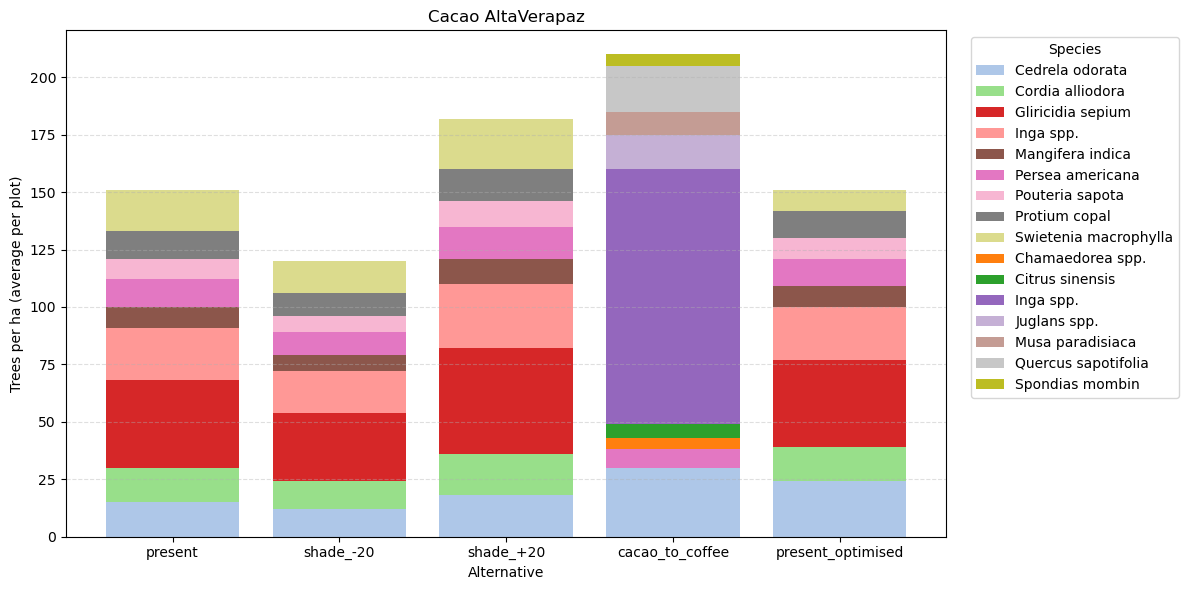

🌳 Plotting shade tree composition for Cacao__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Cacao__DR_Cibao_Noroeste_shade_composition.png


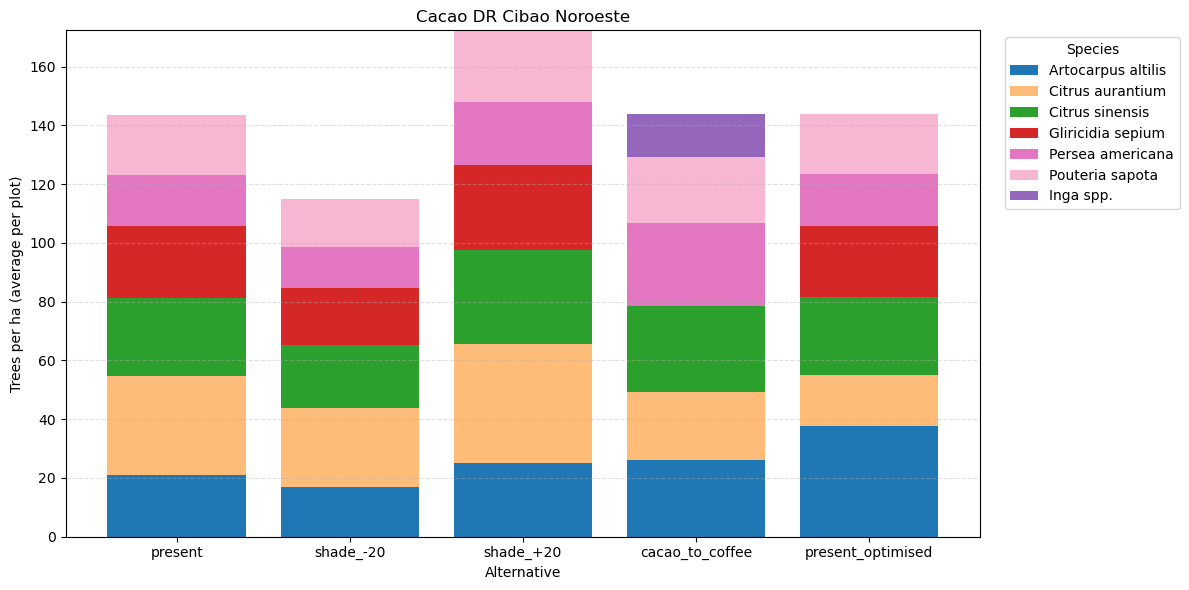

🌳 Plotting shade tree composition for Coffee__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__DR_Cibao_Noroeste_shade_composition.png


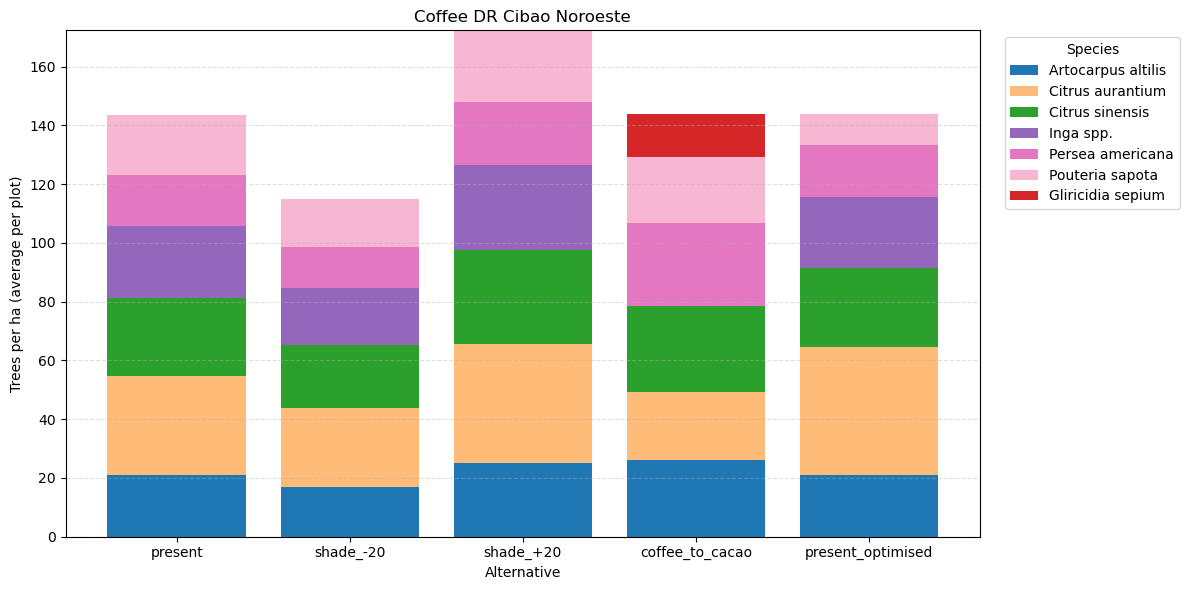

🌳 Plotting shade tree composition for Coffee__Veracruz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__Veracruz_shade_composition.png


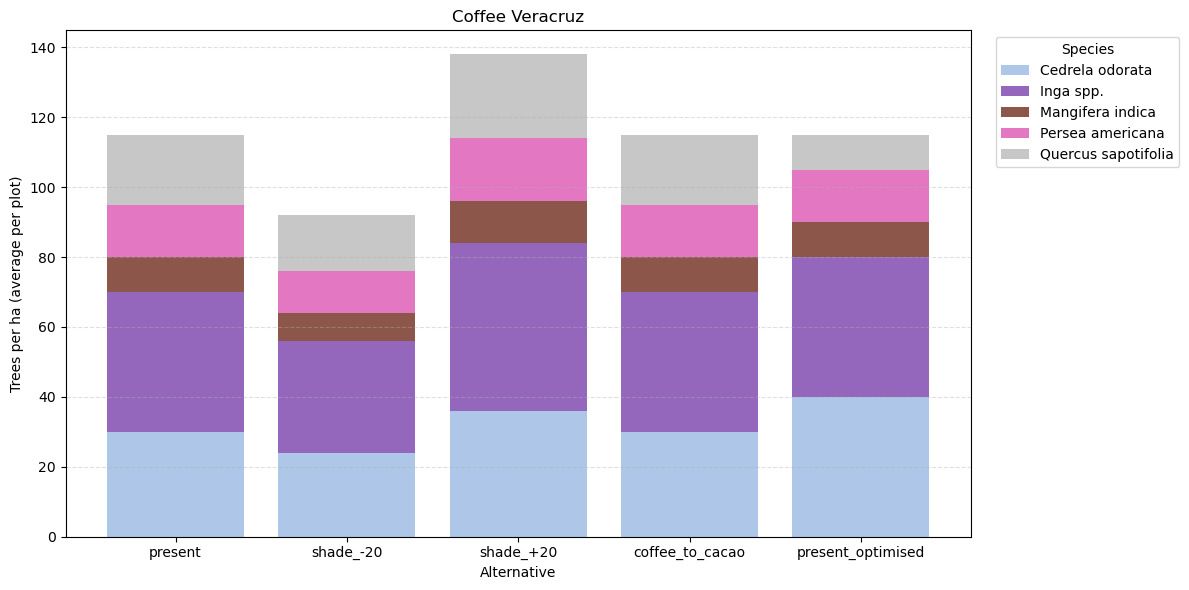

🌳 Plotting shade tree composition for Coffee__WesternHighlands
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__WesternHighlands_shade_composition.png


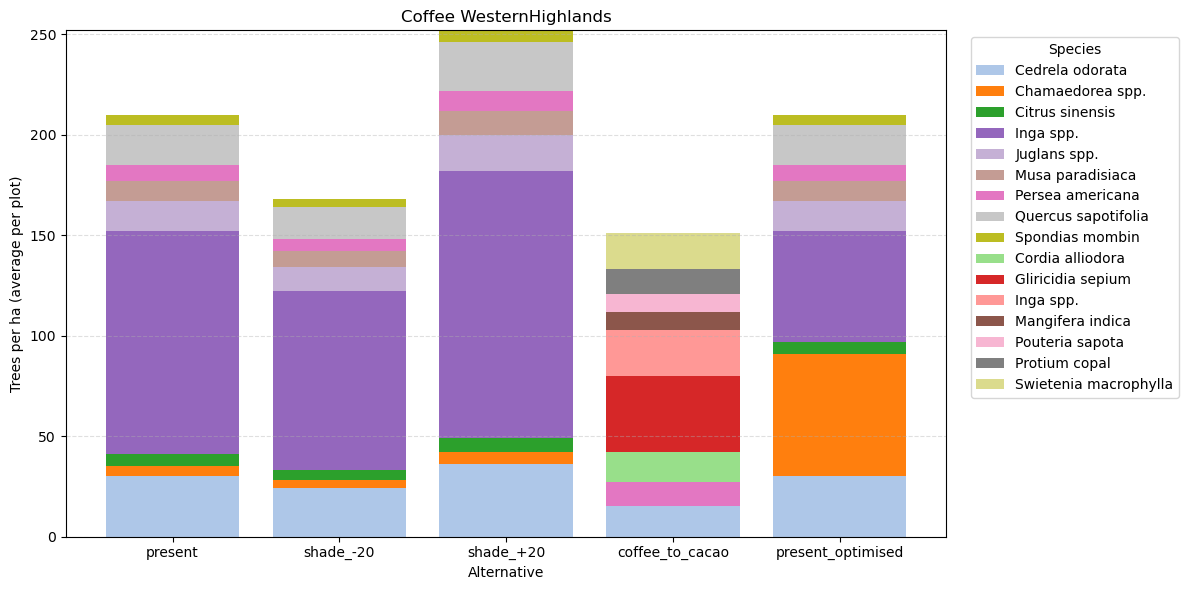

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Which species are considered "main crops"
MAIN_CROPS = {"Coffea arabica", "Theobroma cacao"}
subfolder = os.path.join(FIGURES_DIR, "shade_composition")
os.makedirs(subfolder, exist_ok=True)

# --- Build a global species color map ---
all_species = set()
for alternatives in system_results.values():
    for df in alternatives.values():
        all_species.update(df["species_clean"].unique())

# Exclude main crops from shade composition
all_species = sorted([sp for sp in all_species if sp not in MAIN_CROPS])

# Assign consistent colors
palette = plt.cm.tab20.colors  # 20 distinct colors
species_colors = {
    sp: palette[i % len(palette)] for i, sp in enumerate(all_species)
}

# Legend display mapping (only affects legend text, not data or colors)
species_display_map = {
    "Inga vera": "Inga spp.",
    "Inga sapindoides": "Inga spp."
}

# --- Plot loop ---
for system_name, alternatives in system_results.items():
    print(f"🌳 Plotting shade tree composition for {system_name}")

    comp_summary = []
    for alt_name, df in alternatives.items():
        n_plots = df["geometry"].nunique()

        # exclude main crops
        shade_df = df[~df["Scientific name"].isin(MAIN_CROPS)]

        # total per species, then average per plot
        comp = shade_df.groupby("species_clean")["Plants/ha"].sum() / n_plots
        comp_summary.append(comp.rename(alt_name))

    comp_df = pd.concat(comp_summary, axis=1).fillna(0)

    # Species & alternatives
    species = comp_df.index
    alternatives_list = comp_df.columns

    # --- Stacked bar chart ---
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(alternatives_list))

    for sp in species:
        vals = comp_df.loc[sp].reindex(alternatives_list, fill_value=0)
        ax.bar(alternatives_list, vals,
               bottom=bottom,
               color=species_colors[sp],
               label=sp)
        bottom += vals.values

    # Prettify title
    ax.set_title(system_name.replace("__", " ").replace("_", " "))
    ax.set_ylabel("Trees per ha (average per plot)")
    ax.set_xlabel("Alternative")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # Only show species actually present here
    handles, labels = ax.get_legend_handles_labels()
    labels = [species_display_map.get(lbl, lbl) for lbl in labels]  # rename Inga spp.
    ax.legend(handles, labels, title="Species",
              bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    fname = f"{system_name}_shade_composition.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")

    plt.show()


📊 Plotting stacked species impact breakdown (average per plot) for Cacao__AltaVerapaz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Cacao__AltaVerapaz_suitability_impact_2c.png


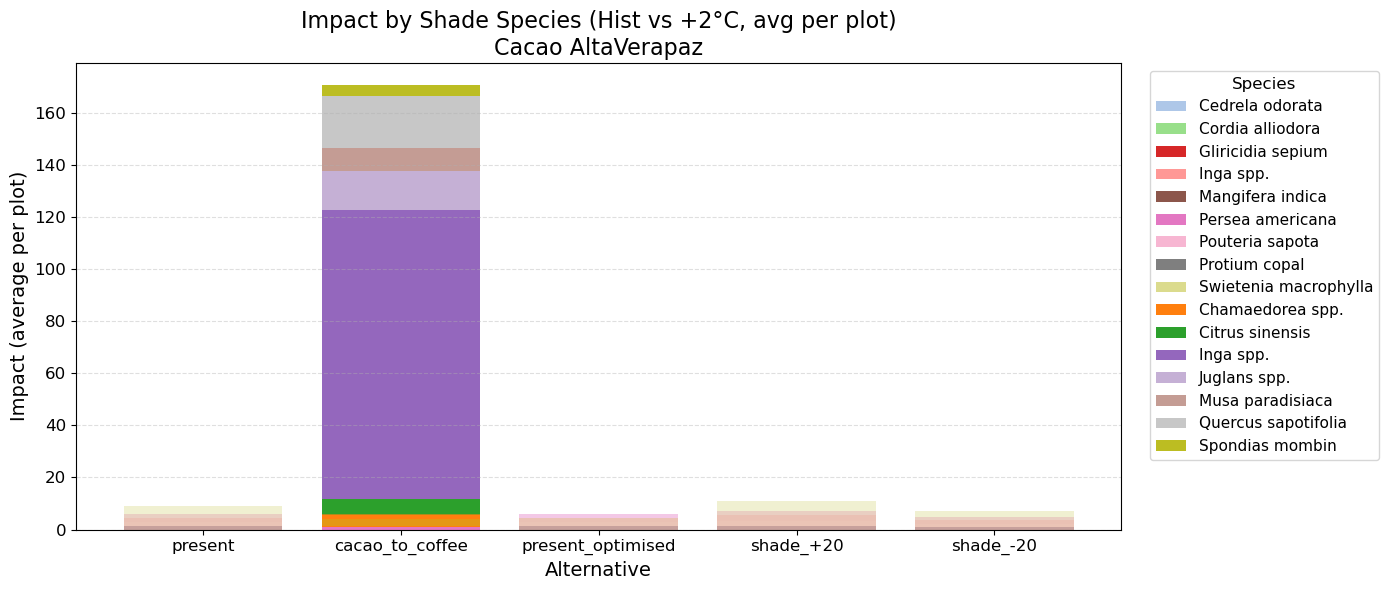

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Cacao__AltaVerapaz_suitability_impact_4c.png


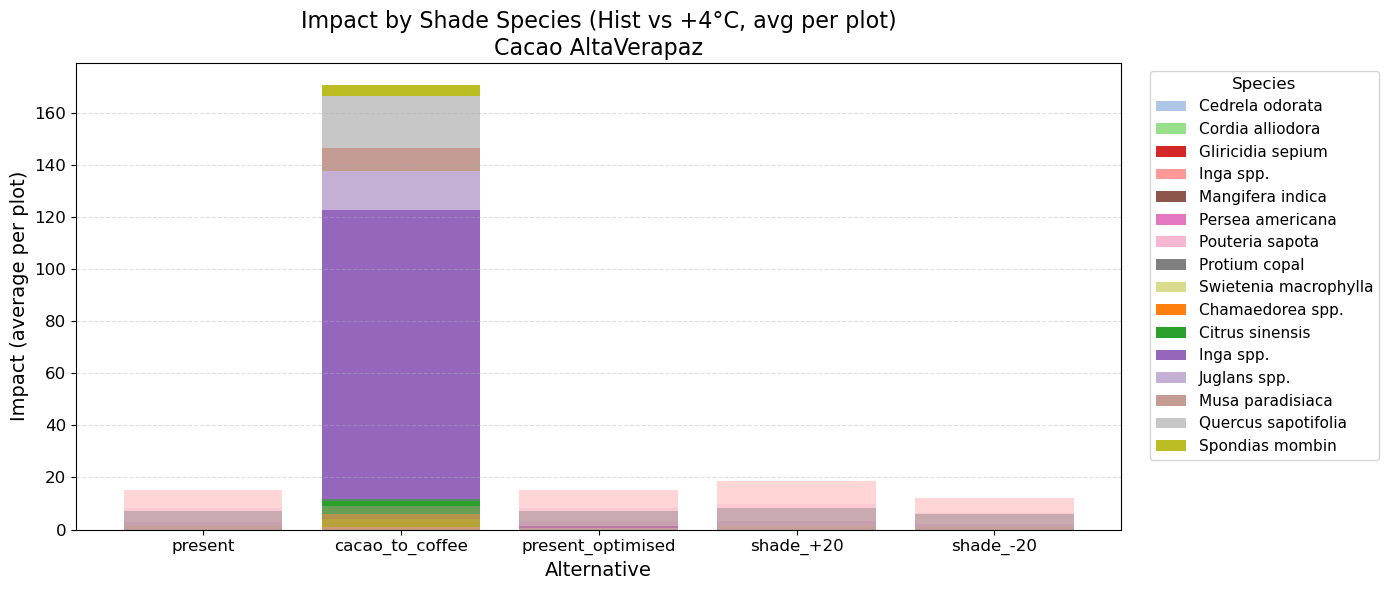

📊 Plotting stacked species impact breakdown (average per plot) for Cacao__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Cacao__DR_Cibao_Noroeste_suitability_impact_2c.png


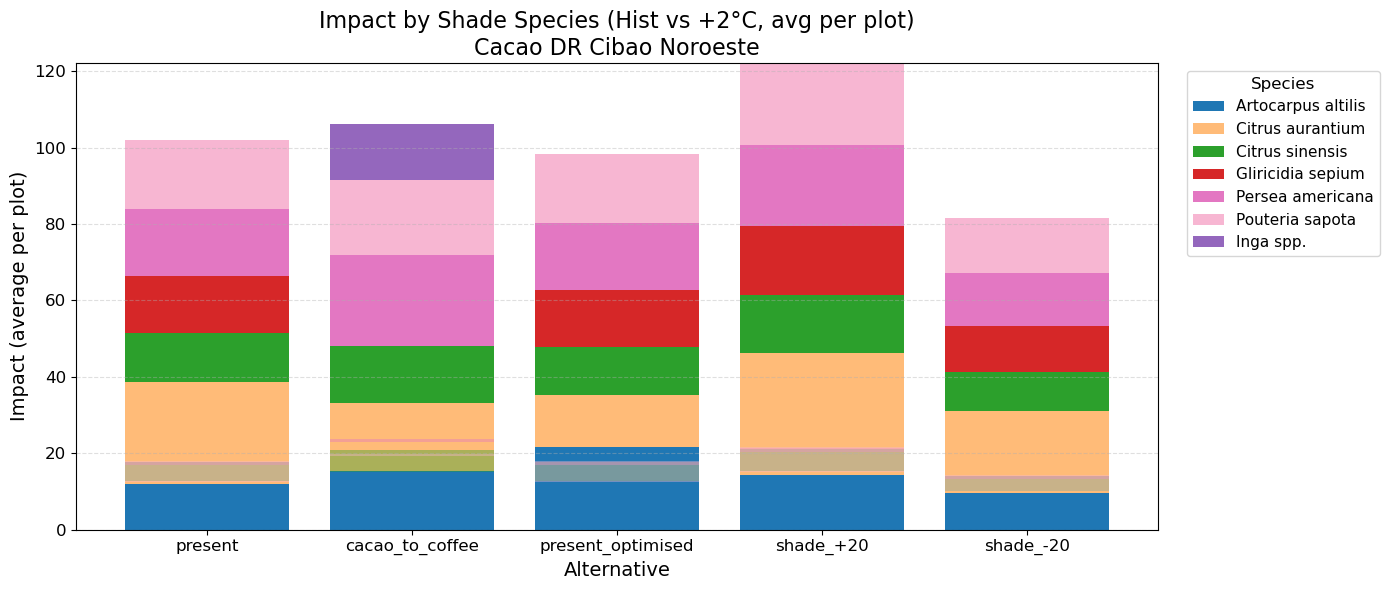

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Cacao__DR_Cibao_Noroeste_suitability_impact_4c.png


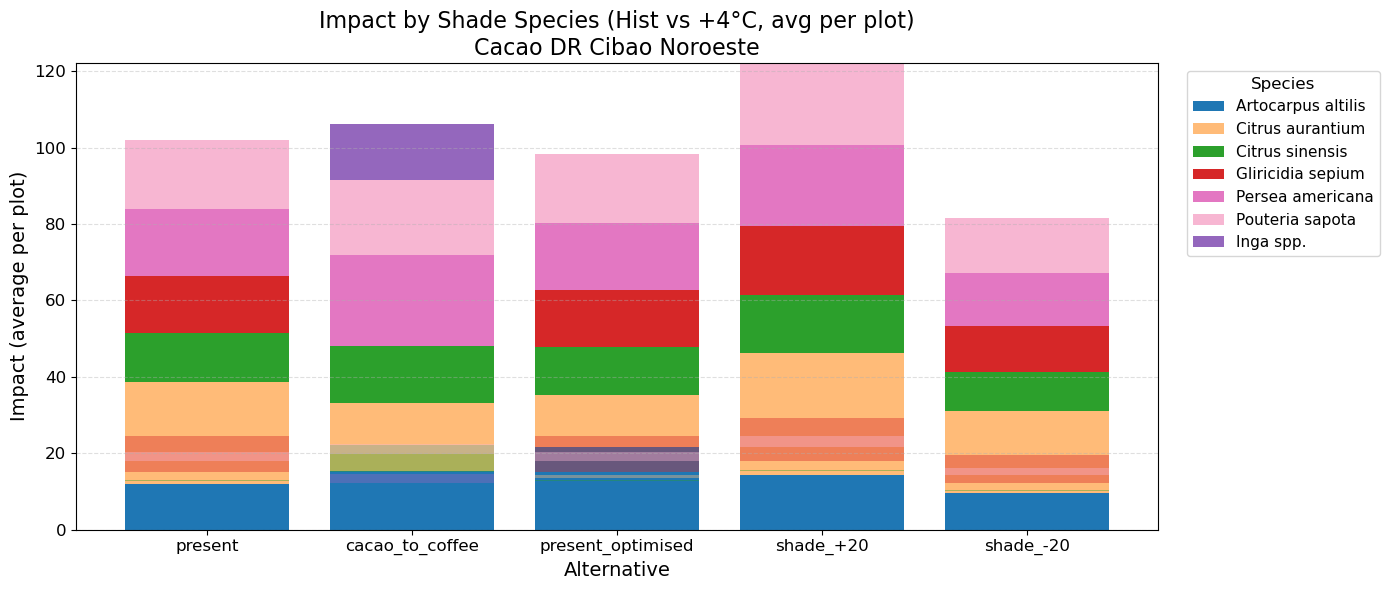

📊 Plotting stacked species impact breakdown (average per plot) for Coffee__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__DR_Cibao_Noroeste_suitability_impact_2c.png


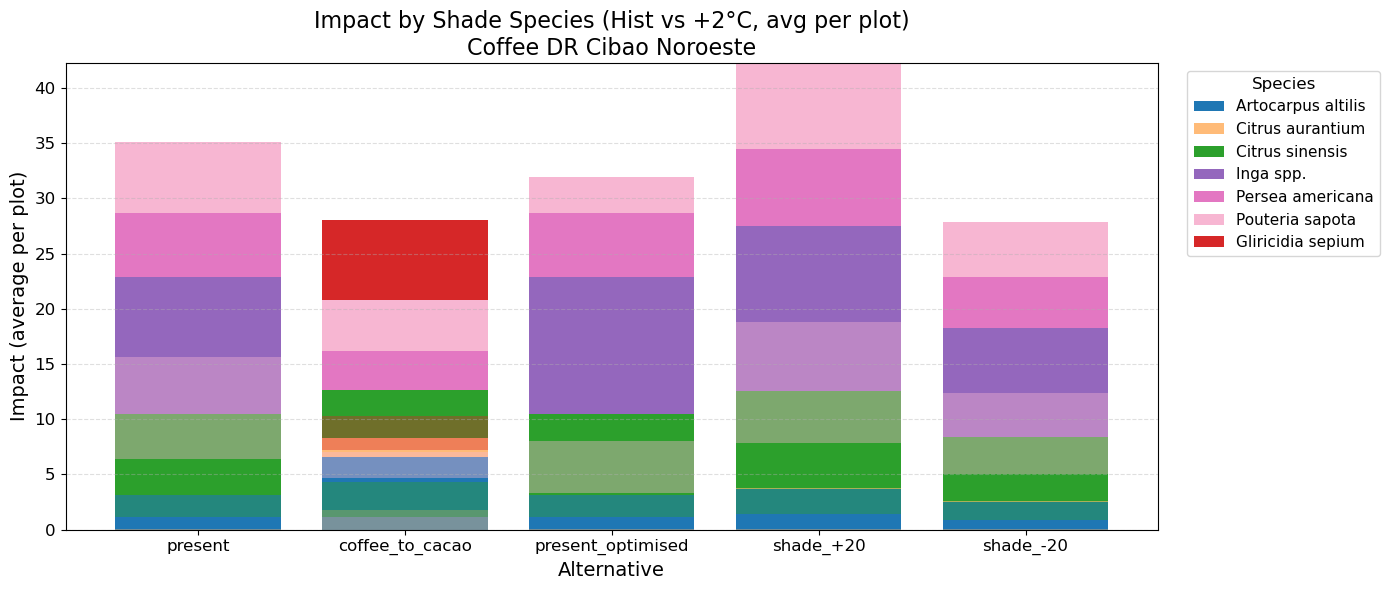

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__DR_Cibao_Noroeste_suitability_impact_4c.png


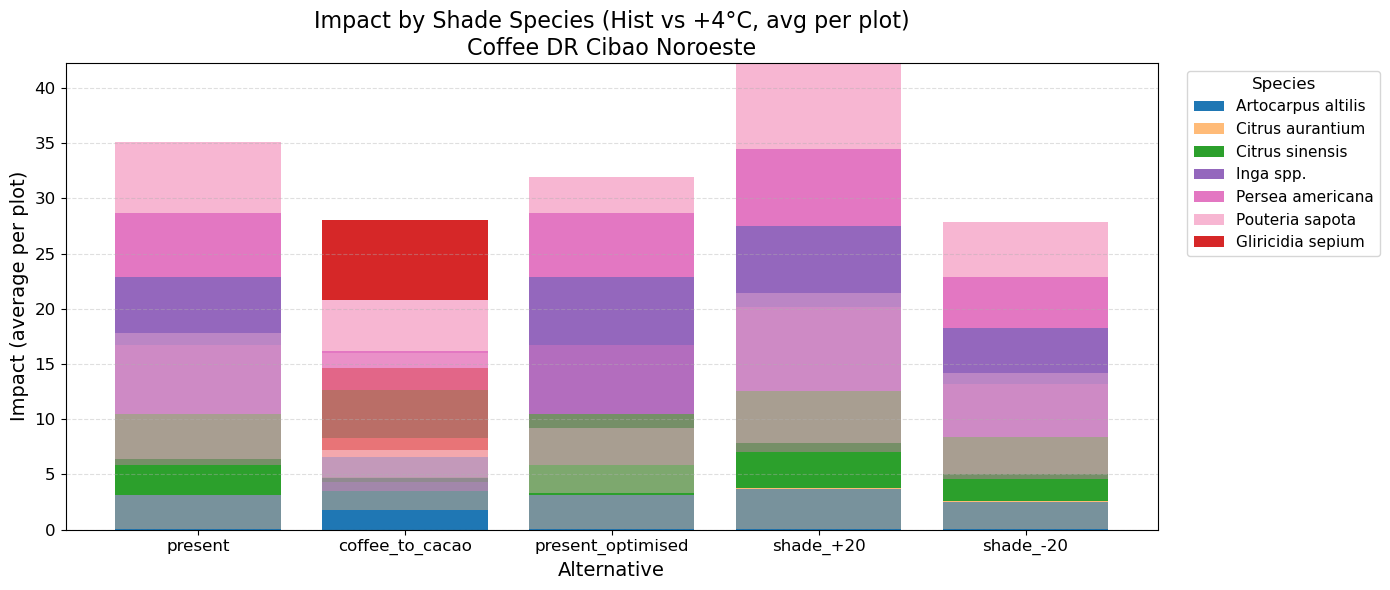

📊 Plotting stacked species impact breakdown (average per plot) for Coffee__Veracruz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__Veracruz_suitability_impact_2c.png


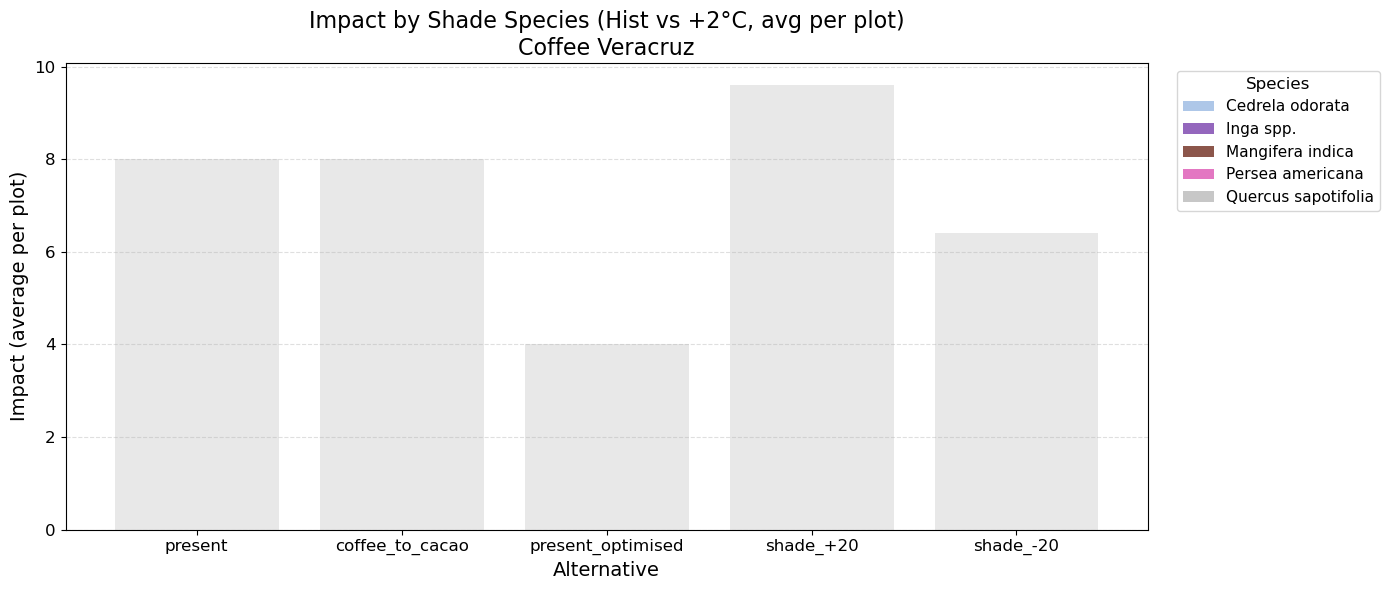

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__Veracruz_suitability_impact_4c.png


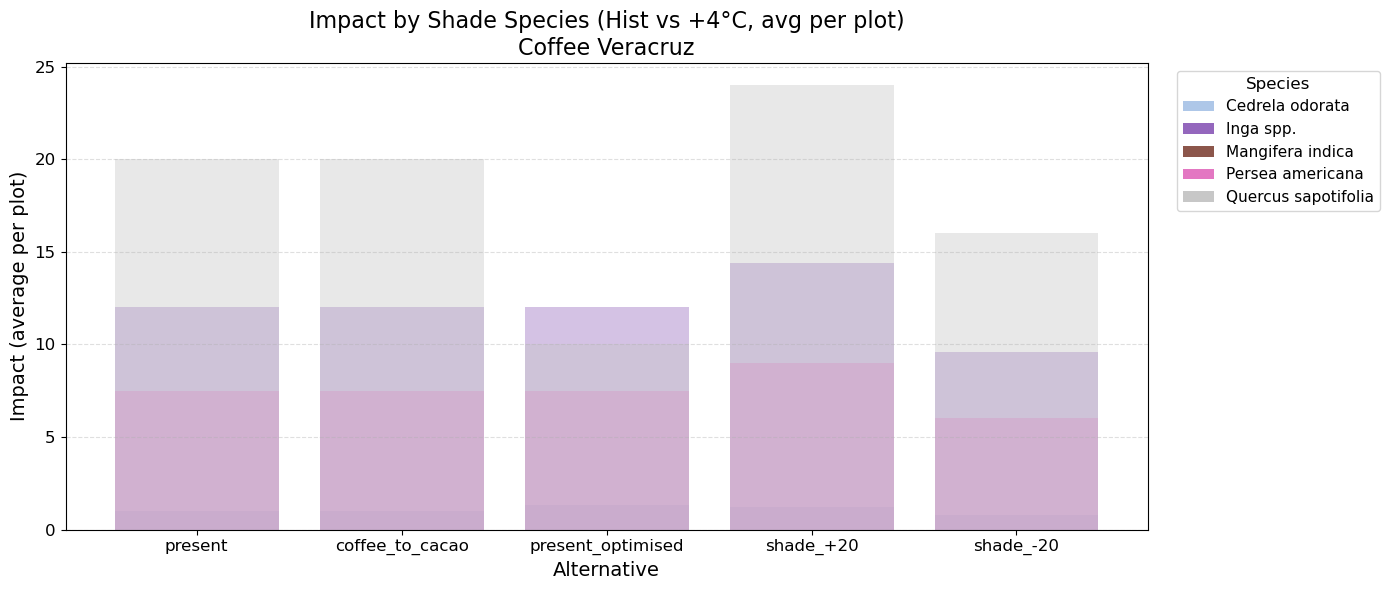

📊 Plotting stacked species impact breakdown (average per plot) for Coffee__WesternHighlands
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__WesternHighlands_suitability_impact_2c.png


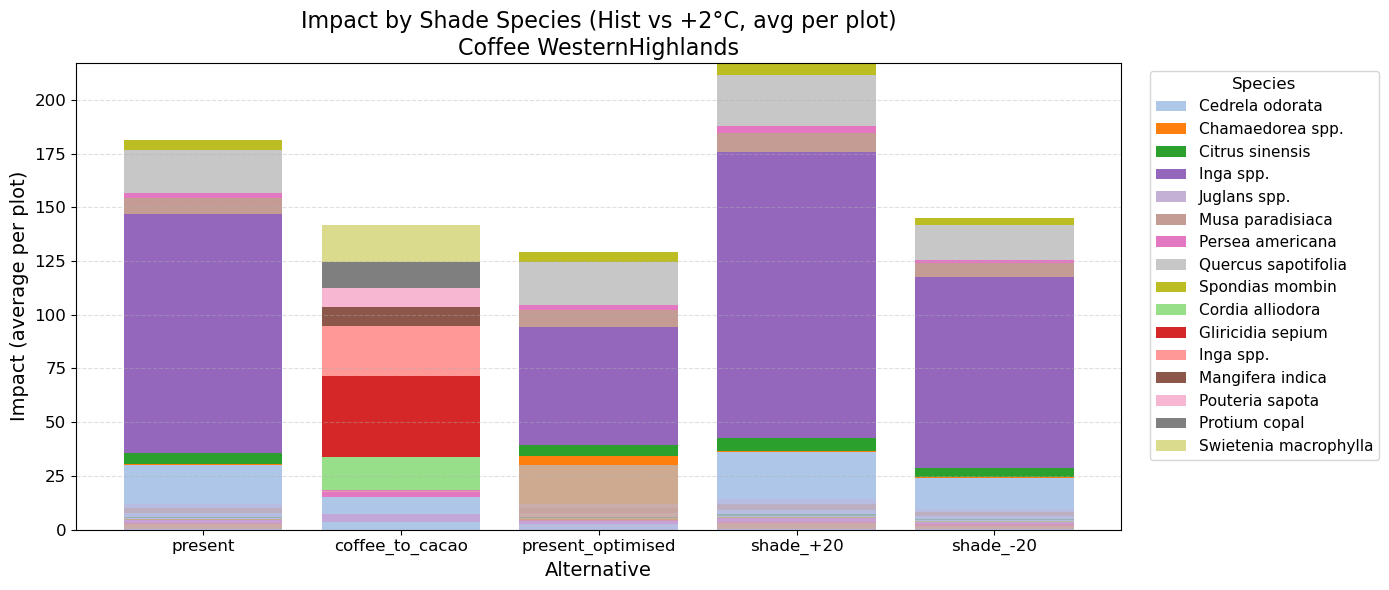

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots/Coffee__WesternHighlands_suitability_impact_4c.png


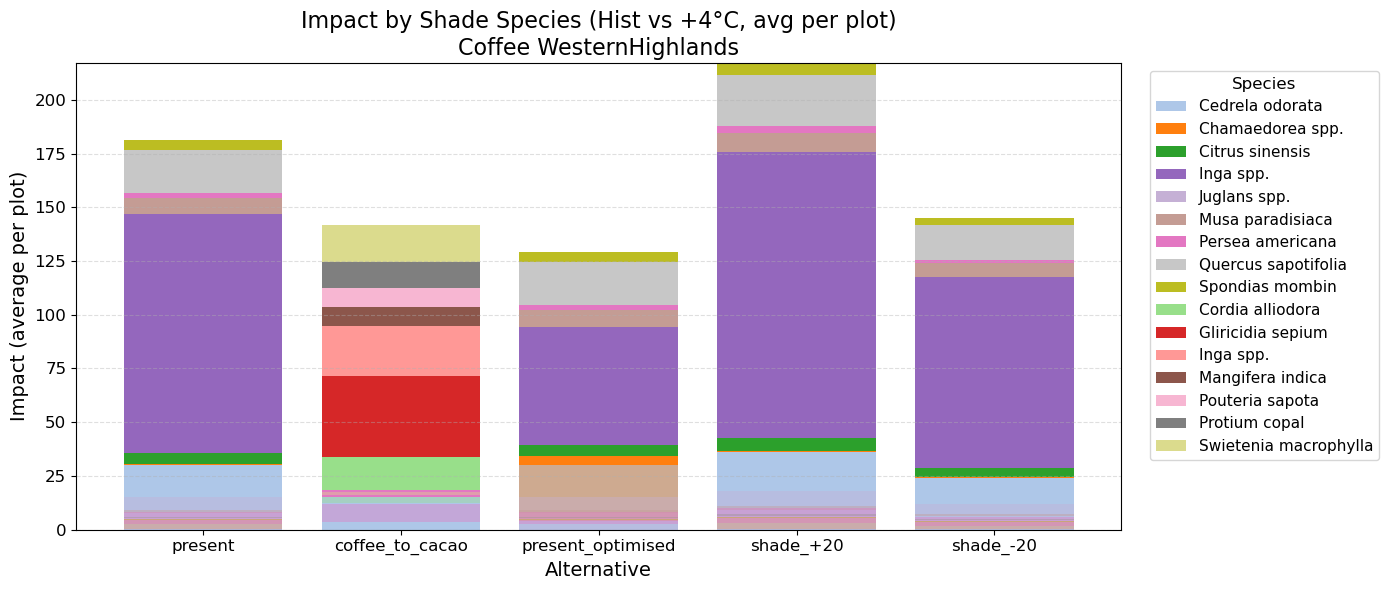

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
})

# Define main crops to exclude
MAIN_CROPS = {"Coffea arabica", "Theobroma cacao"}

subfolder = os.path.join(FIGURES_DIR, "suitability_stacked_barplots")
os.makedirs(subfolder, exist_ok=True)

# --- Build a global species color map ---
all_species = set()
for alternatives in system_results.values():
    for df in alternatives.values():
        all_species.update(df["species_clean"].unique())

# Exclude main crops
all_species = sorted([sp for sp in all_species if sp not in MAIN_CROPS])

palette = plt.cm.tab20.colors
species_colors = {
    sp: palette[i % len(palette)] for i, sp in enumerate(all_species)
}

# Legend display mapping
species_display_map = {
    "Inga vera": "Inga spp.",
    "Inga sapindoides": "Inga spp."
}

# =========================
# LOOP OVER SYSTEMS
# =========================
for system_name, alternatives in system_results.items():
    print(f"📊 Plotting stacked species impact breakdown (average per plot) for {system_name}")

    # ---- Species-level summary of impacts (average per plot) ----
    impacts_summary = []
    for alt_name, gdf in alternatives.items():
        n_plots = gdf["geometry"].nunique()
        tmp = (
            gdf.groupby("species_clean")[["impact_now", "impact_2c", "impact_4c"]]
            .sum()
            .div(n_plots)
            .reset_index()
            .assign(alternative=alt_name)
        )
        impacts_summary.append(tmp)

    impacts_summary = pd.concat(impacts_summary, ignore_index=True)

    # ❌ remove main crops
    impacts_summary = impacts_summary[~impacts_summary["species_clean"].isin(MAIN_CROPS)]

    # Ensure alternatives are ordered
    alternatives_list = sorted(
        impacts_summary["alternative"].unique(),
        key=lambda x: (x != "present", x)
    )

    species = impacts_summary["species_clean"].unique()

    # -------- Plot 1: Historical vs +2°C --------
    fig, ax = plt.subplots(figsize=(14, 6))
    bottom_hist = np.zeros(len(alternatives_list))

    for sp in species:
        subset = impacts_summary[impacts_summary["species_clean"] == sp].set_index("alternative")
        hist_vals = subset["impact_now"].reindex(alternatives_list, fill_value=0)
        vals_2c   = subset["impact_2c"].reindex(alternatives_list, fill_value=0)

        ax.bar(alternatives_list, hist_vals, bottom=bottom_hist,
               color=species_colors[sp], label=sp)
        ax.bar(alternatives_list, vals_2c - hist_vals, bottom=hist_vals,
               color=species_colors[sp], alpha=0.4)

        bottom_hist += hist_vals.values

    title_name = system_name.replace("__", " ").replace("_", " ")
    ax.set_title(f"Impact by Shade Species (Hist vs +2°C, avg per plot)\n{title_name}")
    ax.set_ylabel("Impact (average per plot)")
    ax.set_xlabel("Alternative")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    handles, labels = ax.get_legend_handles_labels()
    labels = [species_display_map.get(lbl, lbl) for lbl in labels]
    ax.legend(handles, labels, title="Species",
              bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    fname = f"{system_name}_suitability_impact_2c.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")
    plt.show()

    # -------- Plot 2: Historical vs +4°C --------
    fig, ax = plt.subplots(figsize=(14, 6))
    bottom_hist = np.zeros(len(alternatives_list))

    for sp in species:
        subset = impacts_summary[impacts_summary["species_clean"] == sp].set_index("alternative")
        hist_vals = subset["impact_now"].reindex(alternatives_list, fill_value=0)
        vals_4c   = subset["impact_4c"].reindex(alternatives_list, fill_value=0)

        ax.bar(alternatives_list, hist_vals, bottom=bottom_hist,
               color=species_colors[sp], label=sp)
        ax.bar(alternatives_list, vals_4c - hist_vals, bottom=hist_vals,
               color=species_colors[sp], alpha=0.4)

        bottom_hist += hist_vals.values

    ax.set_title(f"Impact by Shade Species (Hist vs +4°C, avg per plot)\n{title_name}")
    ax.set_ylabel("Impact (average per plot)")
    ax.set_xlabel("Alternative")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    handles, labels = ax.get_legend_handles_labels()
    labels = [species_display_map.get(lbl, lbl) for lbl in labels]
    ax.legend(handles, labels, title="Species",
              bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    fname = f"{system_name}_suitability_impact_4c.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")
    plt.show()


💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_area_comparaison/suitability_area_difference.png


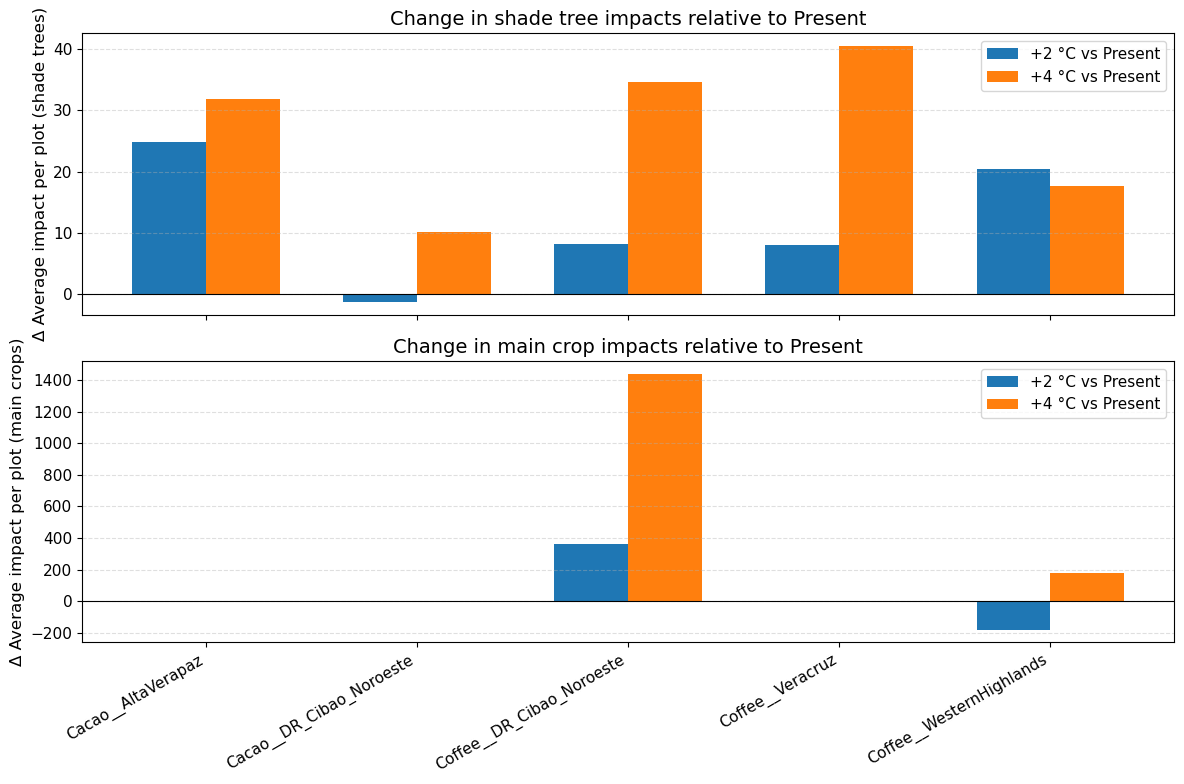

In [28]:
# --- Compute differences ---
diff_shade = impacts_shade.copy()
diff_shade["diff_2c"] = diff_shade["impact_2c"] - diff_shade["impact_now"]
diff_shade["diff_4c"] = diff_shade["impact_4c"] - diff_shade["impact_now"]

diff_main = impacts_main.copy()
diff_main["diff_2c"] = diff_main["impact_2c"] - diff_main["impact_now"]
diff_main["diff_4c"] = diff_main["impact_4c"] - diff_main["impact_now"]

# --- Plot differences ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
x = np.arange(len(diff_shade))
width = 0.35

# Panel 1: Shade trees (Δ impact)
axes[0].bar(x - width/2, diff_shade["diff_2c"], width, label="+2 °C vs Present")
axes[0].bar(x + width/2, diff_shade["diff_4c"], width, label="+4 °C vs Present")
axes[0].set_ylabel("Δ Average impact per plot (shade trees)")
axes[0].set_title("Change in shade tree impacts relative to Present")
axes[0].legend()
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# Panel 2: Main crops (Δ impact)
axes[1].bar(x - width/2, diff_main["diff_2c"], width, label="+2 °C vs Present")
axes[1].bar(x + width/2, diff_main["diff_4c"], width, label="+4 °C vs Present")
axes[1].set_xticks(x)
axes[1].set_xticklabels(impacts_shade["system"], rotation=30, ha="right")
axes[1].set_ylabel("Δ Average impact per plot (main crops)")
axes[1].set_title("Change in main crop impacts relative to Present")
axes[1].legend()
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

# --- Save figure ---
outpath = os.path.join(subfolder, "suitability_area_difference.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"💾 Saved: {outpath}")


In [16]:
df = system_results['Cacao__DR_Cibao_Noroeste']['present']
df[df['Scientific name']=='Theobroma cacao']

Region System  Plot size (ha)            Species  \
0  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
1  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
2  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
3  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
4  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
5  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
6  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
7  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
8  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   
9  DR - Cibao Noroeste  Cacao               1  Cacao (main crop)   

   Scientific name  Plants/ha  Yield (t/ha/year)  Per-tree shading (%)  \
0  Theobroma cacao     1100.0                0.5                   NaN   
1  Theobroma cacao     1100.0                0.5                   NaN   
2  Theobroma cacao     1100.0                0.5                   NaN   
3  Theobroma cacao     1100.0                0.5                   NaN   
4  Theobroma cacao     1100.0                0.5                   NaN   
5  Theobroma cacao     1100.0                0.5                   NaN   
6  Theobroma cacao     1100.0                0.5                   NaN   
7  Theobroma cacao     1100.0                0.5                   NaN   
8  Theobroma cacao     1100.0                0.5                   NaN   
9  Theobroma cacao     1100.0                0.5                   NaN   

    Latitude  Longitude  ...  impf_Swietenia macrophylla impf_Theobroma cacao  \
0  19.466020 -71.218695  ...                         1.0                  2.0   
1  19.078140 -71.721584  ...                         1.0                  2.0   
2  19.395459 -71.406671  ...                         1.0                  2.0   
3  19.231421 -71.683966  ...                         1.0                  2.0   
4  19.346971 -71.472660  ...                         1.0                  2.0   
5  19.229764 -71.654821  ...                         1.0                  2.0   
6  19.311088 -71.691823  ...                         1.0                  2.0   
7  19.349781 -71.427163  ...                         1.0                  2.0   
8  19.797780 -71.348808  ...                         1.0                  2.0   
9  19.021113 -71.528583  ...                         1.0                  2.0   

                     geometry     species_eval  impact_now  impact_2c  \
0  POINT (-71.21870 19.46602)  Theobroma cacao      1100.0     1100.0   
1  POINT (-71.72158 19.07814)  Theobroma cacao      1100.0     1100.0   
2  POINT (-71.40667 19.39546)  Theobroma cacao      1100.0     1100.0   
3  POINT (-71.68397 19.23142)  Theobroma cacao      1100.0     1100.0   
4  POINT (-71.47266 19.34697)  Theobroma cacao      1100.0     1100.0   
5  POINT (-71.65482 19.22976)  Theobroma cacao      1100.0     1100.0   
6  POINT (-71.69182 19.31109)  Theobroma cacao      1100.0     1100.0   
7  POINT (-71.42716 19.34978)  Theobroma cacao      1100.0     1100.0   
8  POINT (-71.34881 19.79778)  Theobroma cacao         0.0        0.0   
9  POINT (-71.52858 19.02111)  Theobroma cacao      1100.0     1100.0   

     impact_4c  frac_loss_now  frac_loss_2c  frac_loss_4c  
0  1100.000000            1.0           1.0  1.000000e+00  
1     0.000721            1.0           1.0  6.556511e-07  
2  1100.000000            1.0           1.0  1.000000e+00  
3  1100.000000            1.0           1.0  1.000000e+00  
4  1100.000000            1.0           1.0  1.000000e+00  
5  1100.000000            1.0           1.0  1.000000e+00  
6  1100.000000            1.0           1.0  1.000000e+00  
7  1100.000000            1.0           1.0  1.000000e+00  
8  1100.000000            0.0           0.0  1.000000e+00  
9  1100.000000            1.0           1.0  1.000000e+00  

[10 rows x 43 columns]

# Let's now also model risks from extreme events

### for now we look just at drought and tropical cyclones, but you could also look at high temepratures and low precipitations

### we are only interested in drought for now. let's just assume a standard vulnerability, all species or similarly vulnerable

In [59]:
import os
from config import bbox
from climada.hazard.base import Hazard
from config import DATA_DIR, TERRACLIMATE_PATHS
from utils_hazards import (
    get_aggregates, compute_spei_3,
    generate_gev_sample_field, create_hazard_from_array
)

# === Settings ===
LON_BOUNDS_DR = (bbox[0], bbox[2])        # (west, east)
LAT_BOUNDS_DR = (bbox[3], bbox[1])        # (north, south)
TERRACLIMATE_PATHS = {
    "plus2C": DATA_DIR / "terra_climate_scenarios_ncss/plus2C",
        "plus4C": DATA_DIR / "terra_climate_scenarios_ncss/plus4C",

    "historical":  DATA_DIR / "terra_climate"
}

haz_types = ["SPEI", "TM"]
output_dir = os.path.join(DATA_DIR, "hazards")
os.makedirs(output_dir, exist_ok=True)

def get_hazard_path(scenario, haz_type):
    return os.path.join(output_dir, f"write_hazard_{scenario}_{haz_type}.hdf5")

def load_hazard_from_file(scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    haz = Hazard.from_hdf5(path)
    print(f"📂 Loaded: {path}")
    return haz

def save_hazard_to_file(hazard, scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    hazard.write_hdf5(path)
    print(f"💾 Saved: {path}")

# === Main loop ===
hazard_dict = {}

for scenario, path in TERRACLIMATE_PATHS.items():
    print(f"\n🚀 Processing scenario: {scenario}")
    all_exist = all(os.path.exists(get_hazard_path(scenario, haz_type)) for haz_type in haz_types)

    if all_exist:
        print("✅ All hazard files found — skipping computation.")
        hazard_dict[scenario] = {
            haz_type: load_hazard_from_file(scenario, haz_type)
            for haz_type in haz_types
        }
        continue

    print("🧮 Computing hazards...")
    tmean, ppt, ppt_monthly, pet_monthly = get_aggregates(path)
    # Mask invalid cells in both arrays
    mask_invalid = np.isnan(ppt_monthly) | np.isnan(pet_monthly)
    ppt_monthly = ppt_monthly.where(~mask_invalid)
    pet_monthly = pet_monthly.where(~mask_invalid)
    print("🌵 Computing SPEI...")
    spei_3 = compute_spei_3(ppt_monthly, pet_monthly)
    spei_yearly = spei_3.groupby(spei_3.time.dt.year).min("time")

    print("🎲 Sampling synthetic HOT, DRY, and DRIEST years (GEV)...")
    tmean_100yrs = generate_gev_sample_field(tmean, n_years=100)
    #ppt_100yrs = generate_gev_sample_field(ppt, n_years=100, invert=True)
    spei_100yrs = generate_gev_sample_field(spei_yearly, n_years=100, invert=True)

    print("🌍 Creating CLIMADA Hazard objects...")
    haz_tmean = create_hazard_from_array(tmean_100yrs, haz_type="TM", units="degC")
    # haz_ppt = create_hazard_from_array(ppt_100yrs, haz_type="PR", units="mm")
    haz_spei = create_hazard_from_array(spei_100yrs, haz_type="SPEI", units="index")

    # Save to disk
    save_hazard_to_file(haz_tmean, scenario, "TM")
    # save_hazard_to_file(haz_ppt, scenario, "PR")
    save_hazard_to_file(haz_spei, scenario, "SPEI")

    hazard_dict[scenario] = {
        "TM": haz_tmean,
        # "PR": haz_ppt,
        "SPEI": haz_spei
    }


🚀 Processing scenario: plus2C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus2C_SPEI.hdf5
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus2C_TM.hdf5

🚀 Processing scenario: plus4C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus4C_SPEI.hdf5
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus4C_TM.hdf5

🚀 Processing scenario: historical
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_historical_SPEI.hdf5
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_historical_TM.hdf5


### let's also load tropical cyclone for the north atlantic and west pacific basins

In [19]:
from climada.util.api_client import Client
from climada.hazard import Hazard

client = Client()

# --- HISTORICAL ---
tc_hist_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "None"}
)
tc_hist_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "None"}
)

tc_hist_all = Hazard.concat([tc_hist_na, tc_hist_ep])

# --- FUTURE (2°C / RCP4.5 around 2060) ---
tc_future_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)
tc_future_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)

tc_future_all = Hazard.concat([tc_future_na, tc_future_ep])




In [60]:
# --- Add to your hazard dictionary ---
hazard_dict['historical']["TC"] = tc_hist_all
hazard_dict["plus2C"]["TC"] = tc_future_all

### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


In [57]:
hazard_dict

{'plus2C': {'SPEI': <climada.hazard.base.Hazard at 0x14dc4e090>,
  'TC': <climada.hazard.base.Hazard at 0x376483f50>},
 'plus4C': {'SPEI': <climada.hazard.base.Hazard at 0x14e9ead10>},
 'historical': {'SPEI': <climada.hazard.base.Hazard at 0x14ea82090>,
  'TC': <climada.hazard.base.Hazard at 0x3b5ee4310>}}

In [63]:
import numpy as np
from climada.entity import ImpactFunc, ImpactFuncSet

# === Tropical cyclone impact functions (wind speed in m/s) ===
def define_tc_impfs():
    impf_set = ImpactFuncSet()
    intensity = np.linspace(0, 70, 15)  # 0–70 m/s

    def make_tc_curve(i, label, onset, cap, scale):
        curve = np.zeros_like(intensity, dtype=float)
        mask = intensity >= onset
        curve[mask] = cap * np.clip(((intensity[mask] - onset) / scale) ** 2, 0, 1)
        curve = np.minimum(curve, cap)
        return ImpactFunc(
            haz_type="TC",
            id=i,
            name=label,
            intensity=intensity,
            mdd=curve,
            paa=np.ones_like(curve),
        )

    # Reduced differences between classes
    impf_set.append(make_tc_curve(
        1, "High vulnerability (fragile/tall shade)", onset=35, cap=0.5, scale=30
    ))
    impf_set.append(make_tc_curve(
        2, "Medium vulnerability (coffee, cacao, fruit)", onset=40, cap=0.45, scale=32
    ))
    impf_set.append(make_tc_curve(
        3, "Low vulnerability (hardwoods/palms)", onset=48, cap=0.35, scale=35
    ))

    # Default: no damage
    impf_set.append(
        ImpactFunc(
            haz_type="TC",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set


# === Drought impact functions (SPEI scale) ===
def define_drought_impfs():
    impf_set = ImpactFuncSet()
    # SPEI values: 0 (normal) to -3 (extreme drought)
    intensity = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3])

    vuln_curves = {
        # High vulnerability: threshold -1.0, max ~0.3
        1: np.array([0, 0, 0.0, 0.0, 0.05, 0.1, 0.15]),
        # Medium vulnerability: threshold -1.5, max ~0.2
        2: np.array([0, 0, 0.0, 0.0, 0.02, 0.05, 0.1]),
        # Low vulnerability: threshold -2.0, max ~0.15
        3: np.array([0, 0, 0.0, 0.0, 0.0, 0.03, 0.05]),
    }

    for i, mdd in vuln_curves.items():
        impf = ImpactFunc(
            haz_type="DR",
            id=i,
            name=f"Drought vulnerability class {i}",
            intensity=intensity,
            mdd=mdd,
            paa=np.ones_like(mdd),
        )
        impf.mdr = impf.mdd * impf.paa
        impf.check()
        impf_set.append(impf)

    impf_set.append(
        ImpactFunc(
            haz_type="DR",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set


# === Heat (tmean) impact functions (degC) ===
def define_heat_impfs():
    impf_set = ImpactFuncSet()
    # Use a high range to only penalise extreme chronic heat
    intensity = np.linspace(20, 35, 16)  # mean annual temperature

    def make_heat_curve(i, label, onset, cap, scale):
        curve = np.zeros_like(intensity, dtype=float)
        mask = intensity >= onset
        curve[mask] = cap * np.clip(((intensity[mask] - onset) / scale) ** 2, 0, 1)
        curve = np.minimum(curve, cap)
        return ImpactFunc(
            haz_type="TM",
            id=i,
            name=label,
            intensity=intensity,
            mdd=curve,
            paa=np.ones_like(curve),
        )

    # High vulnerability: sensitive crops (coffee, cacao) → damage only from ~27°C
    impf_set.append(make_heat_curve(
        1, "High vulnerability (coffee, cacao)", onset=28, cap=0.4, scale=4
    ))

    # Medium vulnerability: fruit trees → threshold ~29°C
    impf_set.append(make_heat_curve(
        2, "Medium vulnerability (fruit trees)", onset=30, cap=0.3, scale=4
    ))

    # Low vulnerability: tolerant hardwoods → threshold ~31°C
    impf_set.append(make_heat_curve(
        3, "Low vulnerability (hardwoods/palms)", onset=32, cap=0.2, scale=4
    ))

    # Default: no damage
    impf_set.append(
        ImpactFunc(
            haz_type="TM",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set






In [64]:
import numpy as np
import pandas as pd
from climada.entity import ImpactFunc, ImpactFuncSet

# === Species vulnerability mapping ===
species_tc_map = {
    "Coffea arabica": 2,
    "Theobroma cacao": 2,
    "Musa paradisiaca": 1,
    "Gliricidia sepium": 1,
    "Inga vera": 1,
    "Inga sapindoides": 1,
    "Mimosa scabrella": 1,
    "Enterolobium cyclocarpum": 1,
    "Swietenia macrophylla": 3,
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Juglans spp.": 3,
    "Mangifera indica": 2,
    "Citrus aurantium": 2,
    "Citrus sinensis": 2,
    "Persea americana": 2,
    "Pouteria sapota": 2,
    "Artocarpus altilis": 2,
    "Spondias mombin": 2,
    "Protium copal": 2,
    "Chamaedorea spp.": 3,
}

species_dr_map = {
    "Coffea arabica": 1,
    "Theobroma cacao": 1,
    "Musa paradisiaca": 1,
    "Gliricidia sepium": 3,
    "Inga vera": 2,
    "Inga sapindoides": 2,
    "Mimosa scabrella": 3,
    "Enterolobium cyclocarpum": 3,
    "Swietenia macrophylla": 3,
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Juglans spp.": 3,
    "Mangifera indica": 2,
    "Citrus aurantium": 2,
    "Citrus sinensis": 2,
    "Persea americana": 1,
    "Pouteria sapota": 2,
    "Artocarpus altilis": 1,
    "Spondias mombin": 2,
    "Protium copal": 2,
    "Chamaedorea spp.": 3,
}

species_tm_map = {
    "Coffea arabica": 1,     # high vulnerability to extreme heat
    "Theobroma cacao": 1,
    "Musa paradisiaca": 2,   # medium
    "Mangifera indica": 2,
    "Persea americana": 2,
    "Swietenia macrophylla": 3,  # low
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Chamaedorea spp.": 3,
}

# === Assign IMPF IDs (species-based) ===
def assign_impact_function_ids(df):
    df["impf_TC"] = df["species_clean"].map(species_tc_map).fillna(0).astype(int)
    df["impf_DR"] = df["species_clean"].map(species_dr_map).fillna(0).astype(int)
    df["impf_TM"] = df["species_clean"].map(species_tm_map).fillna(0).astype(int)
    return df

# === Build ImpactFuncSets ===
tc_impfs = define_tc_impfs()
dr_impfs = define_drought_impfs()
tm_impfs = define_heat_impfs()


2025-08-26 16:27:23,348 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-26 16:27:23,350 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-26 16:27:23,351 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


In [65]:
from climada.entity import Exposures
import pandas as pd

def adjust_with_scenario(row, alt_name):
    """Adjust IMPF classes based on scenario name (shade changes)."""
    dr_class, heat_class, tc_class = row["impf_DR"], row["impf_TM"], row["impf_TC"]

    if "-20" in alt_name:  # less shade
        heat_class = max(1, heat_class - 1)   # heat: more vulnerable
        dr_class   = min(3, dr_class + 1)     # drought: less vulnerable
        tc_class   = max(1, tc_class - 1)     # cyclones: more vulnerable

    elif "+20" in alt_name or "shadeplus" in alt_name:  # more shade
        heat_class = min(3, heat_class + 1)   # heat: less vulnerable
        dr_class   = max(1, dr_class - 1)     # drought: more vulnerable
        tc_class   = min(3, tc_class + 1)     # cyclones: less vulnerable

    # If no shade modifier in alt_name → leave unchanged
    return pd.Series([dr_class, heat_class, tc_class],
                     index=["impf_DR", "impf_TM", "impf_TC"])

# === Assign impact functions to *all* exposures ===
for system_name, alternatives in exposures.items():
    for alt_name, exp in alternatives.items():
        gdf = exposures[system_name][alt_name].gdf

        # --- Step 1: species-based mapping ---
        gdf = assign_impact_function_ids(gdf)

        # --- Step 2: adjust based on scenario name ---
        gdf[["impf_DR", "impf_TM", "impf_TC"]] = gdf.apply(
            lambda row: adjust_with_scenario(row, alt_name), axis=1
        )

        # Exposure value = number of plants
        gdf.value = gdf["Plants/ha"]

        # Replace back in dict
        exposures[system_name][alt_name] = Exposures(gdf)

        print(f"✅ Assigned IMPFs (species + shade adjustment from scenario) for {system_name} | {alt_name}")


✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | present
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | shade_-20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | shade_+20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | cacao_to_coffee
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | present_optimised
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | present
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | shade_-20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | shade_+20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | cacao_to_coffee
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | present_optimi

In [66]:
for scenario in hazard_dict:
    hazard_dict[scenario]['SPEI'].intensity = -hazard_dict[scenario]['SPEI'].intensity #climada struggles with negative hazard values
    for haz in hazard_dict[scenario]:
        hazard_dict[scenario][haz].event_id = np.array(hazard_dict[scenario][haz].event_id)

In [67]:
import copy
from climada.engine import ImpactCalc
from climada.entity import ImpactFuncSet

# === Helper: merge multiple ImpactFuncSets into one ===
def merge_impf_sets(*sets):
    merged = ImpactFuncSet()
    for s in sets:
        for haz_type, funcs in s.get_func().items():
            for _, func in funcs.items():
                merged.append(func)
    return merged

# === Merge your TC + DR impact functions ===
impf_set = merge_impf_sets(tc_impfs, dr_impfs, tm_impfs)

# === Loop through systems and compute impacts ===
impact_results = {}
for system_name, alternatives in exposures.items():
    print(system_name)

    impact_results[system_name] = {}
    print(system_name)
    for alt_name, exp in alternatives.items():
        print(f"📂 {system_name} - {alt_name}")
        impact_results[system_name][alt_name] = {}

        for scenario in hazard_dict:
            impact_results[system_name][alt_name][scenario] = {}

            for haz_type in hazard_dict[scenario]:
                print(haz_type)
                # ✅ Normalise hazard type (copy so we don’t mutate hazard_dict)
                haz_type_norm = "DR" if haz_type == "SPEI" else haz_type
                
                hazard_dict[scenario][haz_type].haz_type = haz_type_norm
                # ✅ Use merged impact function set
                impact = ImpactCalc(exp, impf_set, hazard_dict[scenario][haz_type]).impact(save_mat=True)
                impact_results[system_name][alt_name][scenario][haz_type_norm] = impact

print(f"✅ Finished impacts for {len(impact_results)} systems")


2025-08-26 16:27:30,808 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-26 16:27:30,810 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-26 16:27:30,811 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
Cacao__AltaVerapaz
Cacao__AltaVerapaz
📂 Cacao__AltaVerapaz - present
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__AltaVerapaz - shade_-20
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__AltaVerapaz - shade_+20
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__AltaVerapaz - cacao_to_coffee
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__AltaVerapaz - present_optimised
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
Cacao__DR_Cibao_Noroeste
Cacao__DR_Cibao_Noroeste
📂 Cacao__DR_Cibao_Noroeste - present
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__DR_Cibao_Noroeste - shade_-20
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__DR_Cibao_Noroeste - shade_+20
SPEI
TM
TC
SPEI
TM
SPEI
TM
TC
📂 Cacao__DR_Cibao_Noroeste - cacao_to_cof

In [56]:
impact_results['Cacao__AltaVerapaz']['present_optimised']

{'plus2C': {'DR': <climada.engine.impact.Impact at 0x44d8e7d90>,
  'TC': <climada.engine.impact.Impact at 0x44d8ef490>},
 'plus4C': {'DR': <climada.engine.impact.Impact at 0x14a917c10>},
 'historical': {'DR': <climada.engine.impact.Impact at 0x44d8dc4d0>,
  'TC': <climada.engine.impact.Impact at 0x44d8d7450>}}

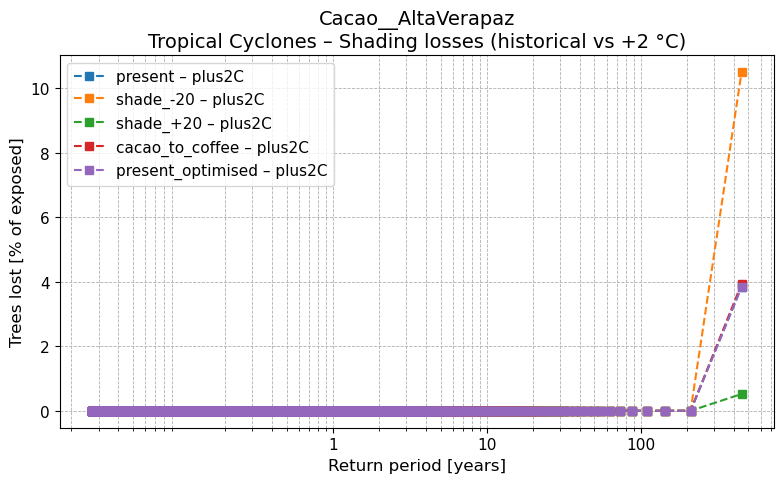

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__AltaVerapaz_TC.png


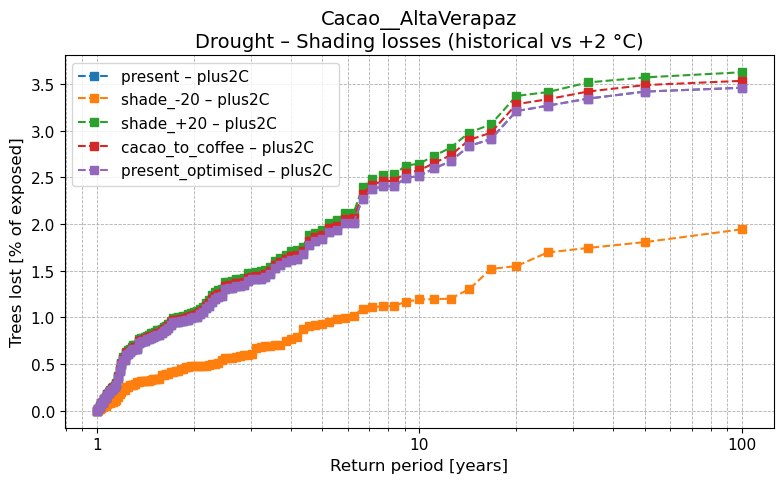

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__AltaVerapaz_DR.png


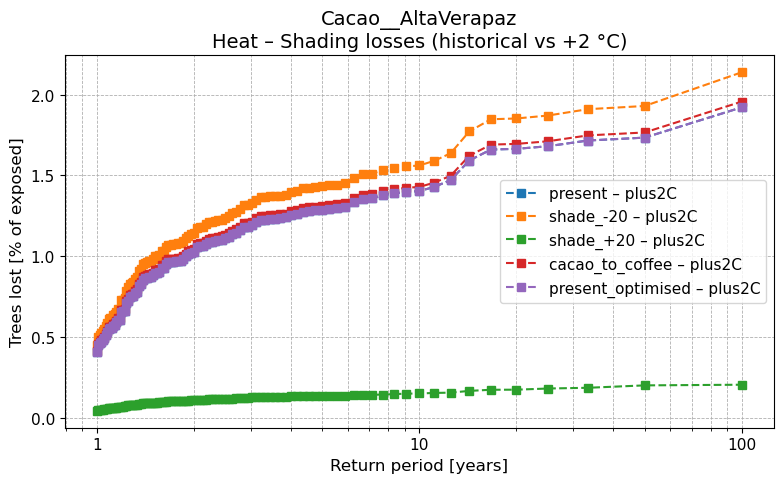

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__AltaVerapaz_TM.png


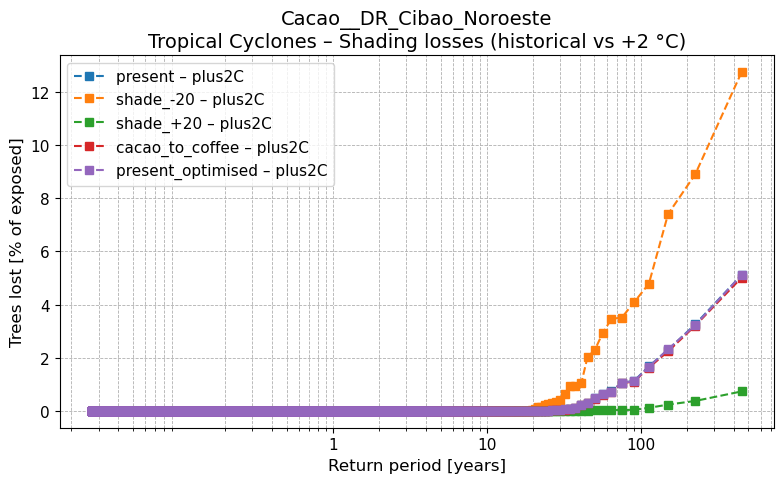

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__DR_Cibao_Noroeste_TC.png


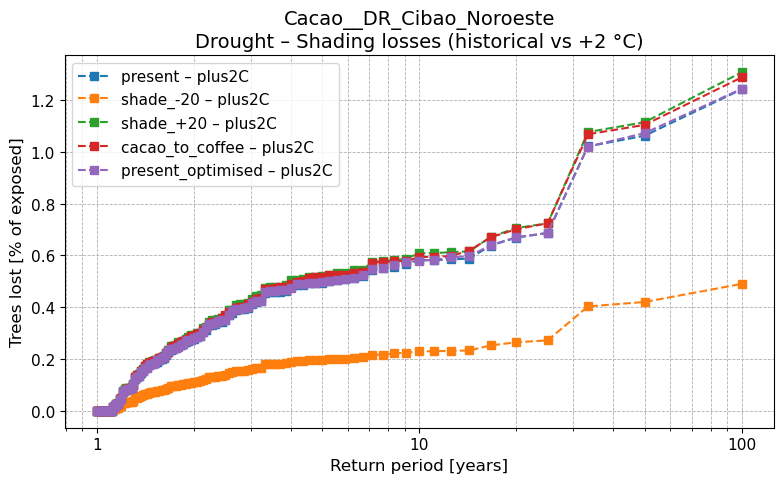

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__DR_Cibao_Noroeste_DR.png


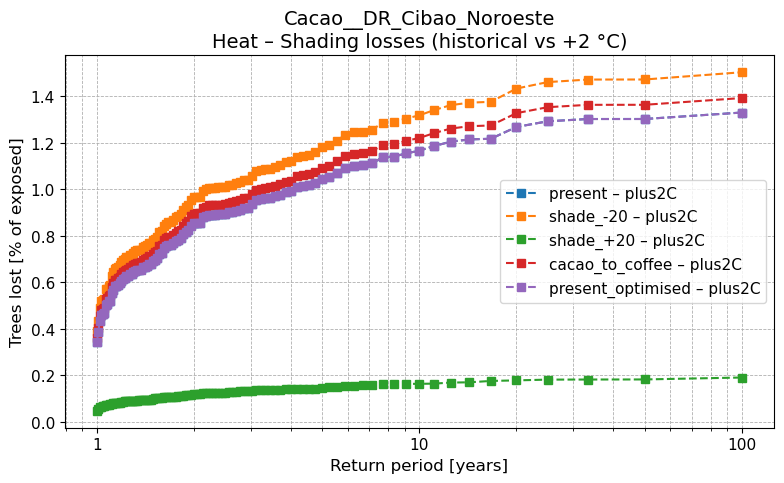

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__DR_Cibao_Noroeste_TM.png


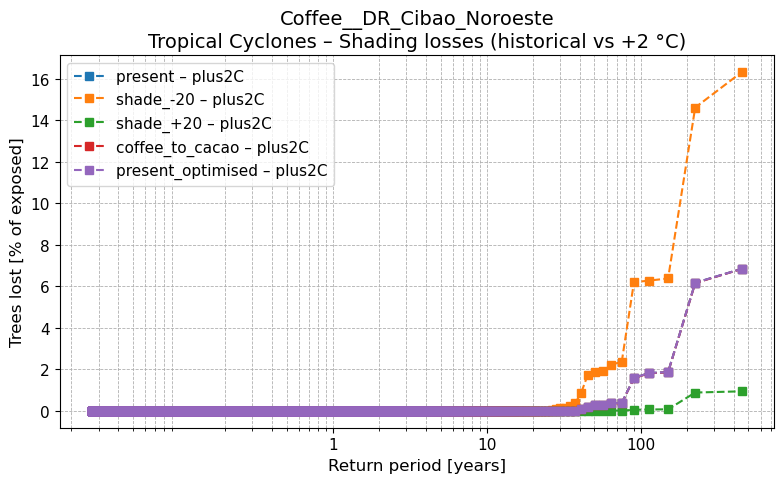

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__DR_Cibao_Noroeste_TC.png


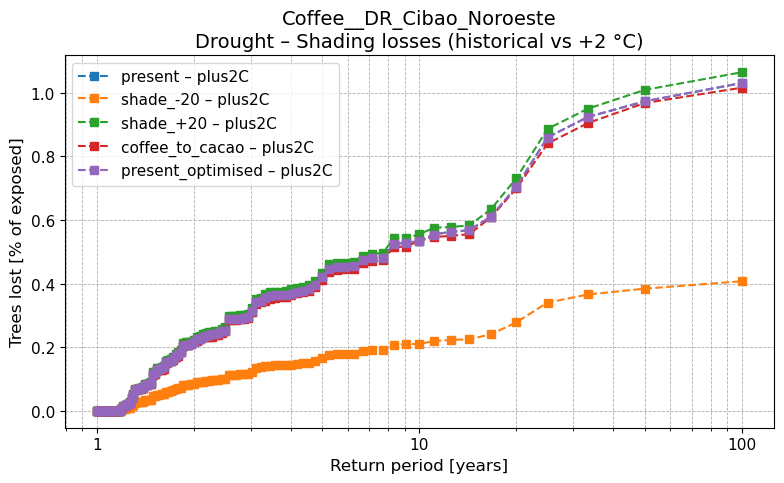

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__DR_Cibao_Noroeste_DR.png


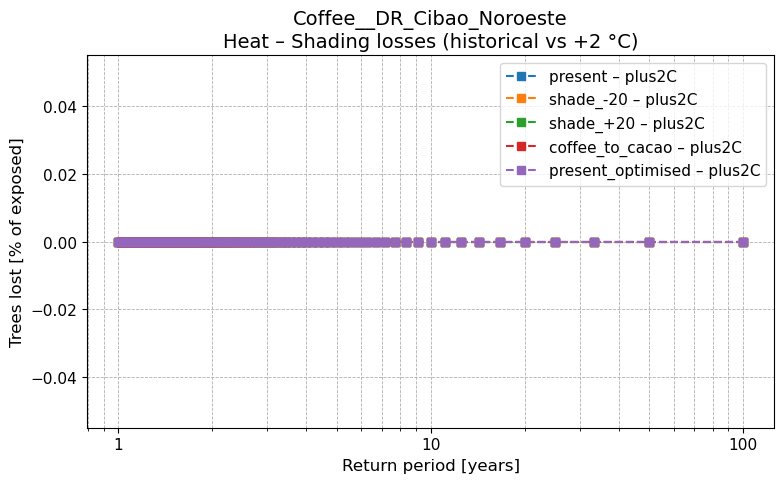

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__DR_Cibao_Noroeste_TM.png


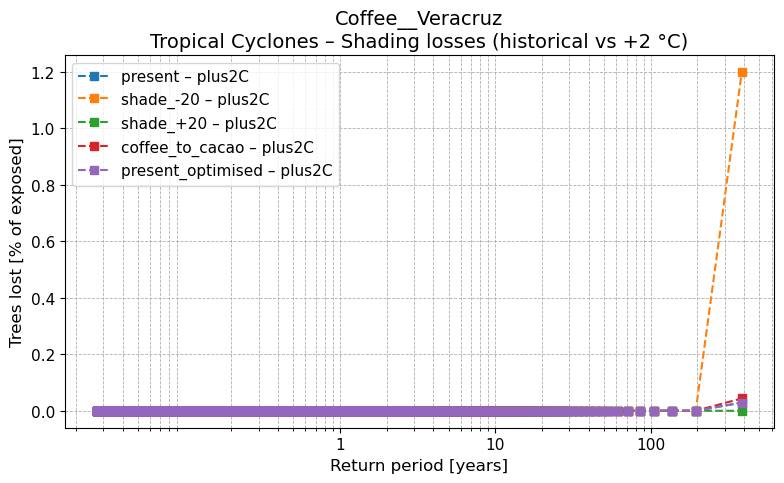

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__Veracruz_TC.png


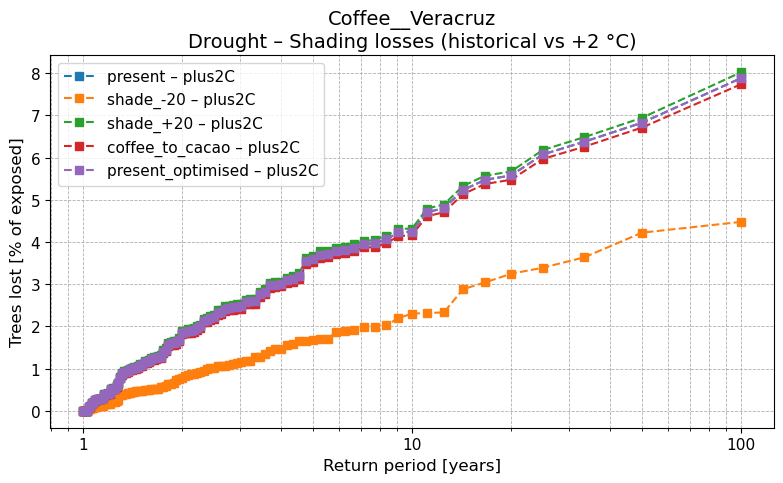

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__Veracruz_DR.png


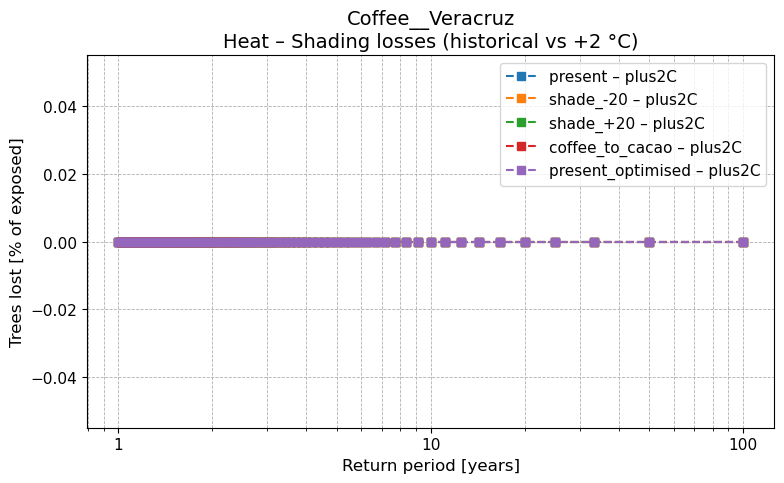

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__Veracruz_TM.png


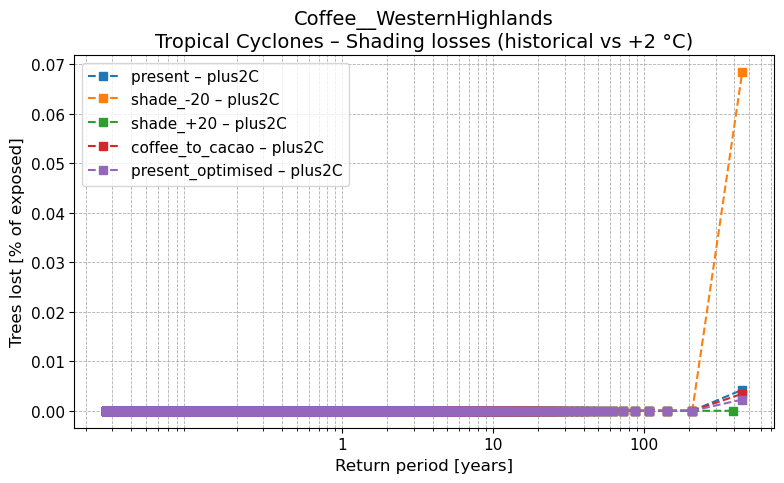

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__WesternHighlands_TC.png


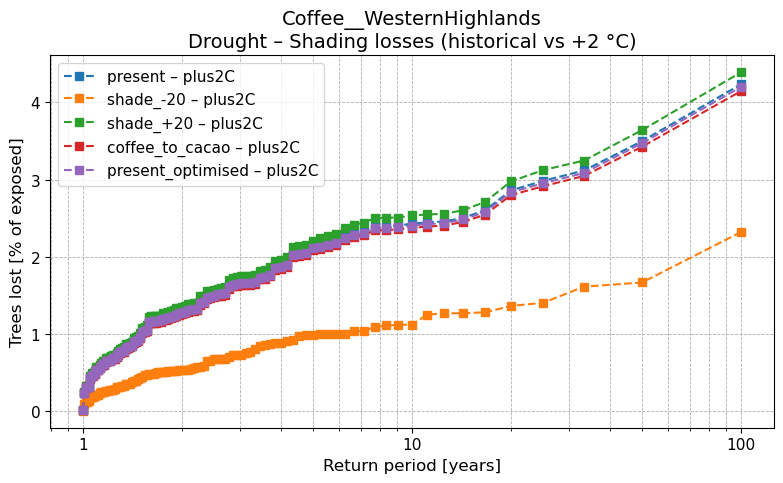

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__WesternHighlands_DR.png


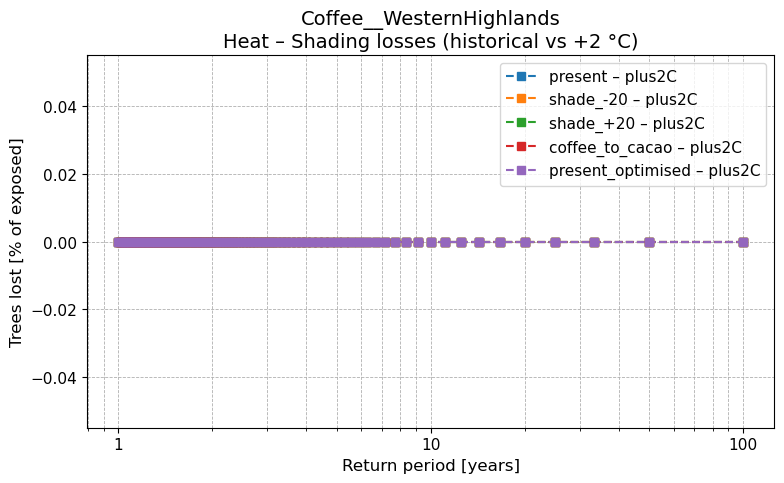

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__WesternHighlands_TM.png


In [68]:
import os
import matplotlib.pyplot as plt

# === Matplotlib style ===
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

hazards_to_plot = {
    "TC": "Tropical Cyclones",
    "DR": "Drought",
    "TM": "Heat"
}

# Create subdirectory inside FIGURES_DIR
out_dir = os.path.join(FIGURES_DIR, "freq_curves")
os.makedirs(out_dir, exist_ok=True)

# === Loop through systems and hazards ===
for system_name, alternatives in impact_results.items():
    for haz_code, haz_label in hazards_to_plot.items():
        plt.figure(figsize=(8, 5))

        for alt_name, haz_dict in alternatives.items():
            for scenario, style in [("plus2C", "--")]:
                impact = haz_dict[scenario][haz_code]
                freq_curve = impact.calc_freq_curve()

                # Normalise by total trees (value column = number of trees)
                total_trees = exposures[system_name][alt_name].gdf.value.sum()
                perc_loss = (freq_curve.impact / total_trees) * 100

                plt.plot(
                    freq_curve.return_per,
                    perc_loss,
                    label=f"{alt_name} – {scenario}",
                    linestyle=style,
                    marker="s",
                )

        plt.xlabel("Return period [years]")
        plt.ylabel("Trees lost [% of exposed]")
        plt.title(f"{system_name}\n{haz_label} – Shading losses (historical vs +2 °C)")
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.6)
        plt.xscale("log")
        plt.xticks([1, 10, 100], labels=["1", "10", "100"])
        plt.tight_layout()

        # Save to file (system + hazard code)
        fname = f"{system_name}_{haz_code}.png"
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.show()

        print(f"💾 Saved: {fpath}")


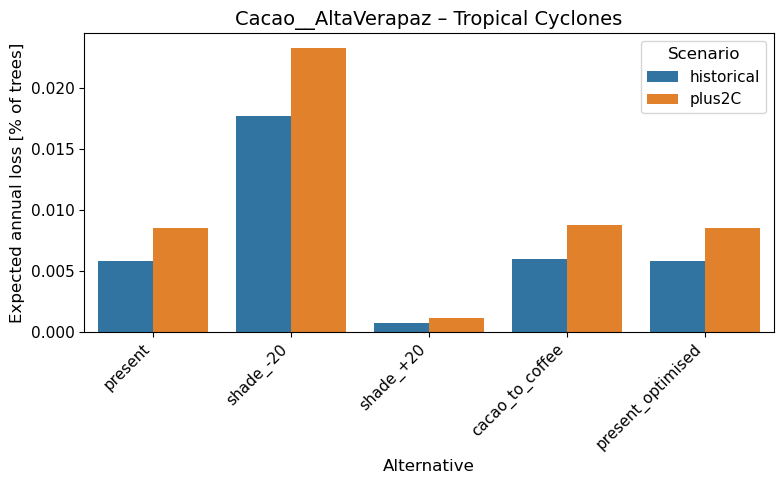

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__AltaVerapaz_TC_barplot.png


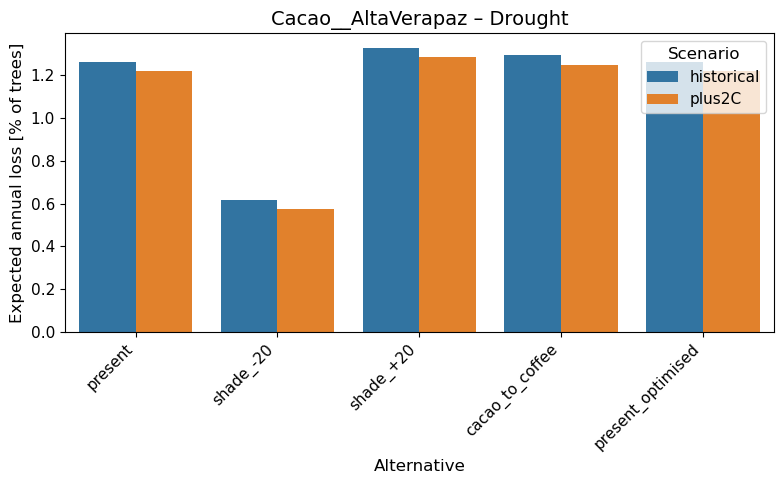

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__AltaVerapaz_DR_barplot.png


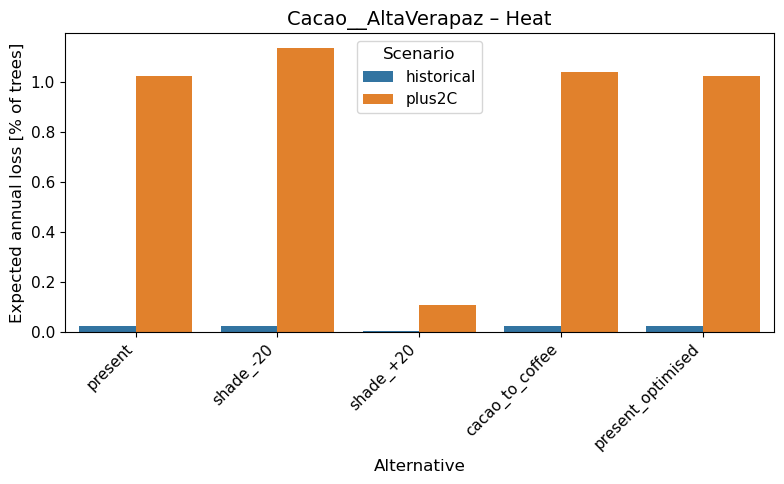

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__AltaVerapaz_TM_barplot.png


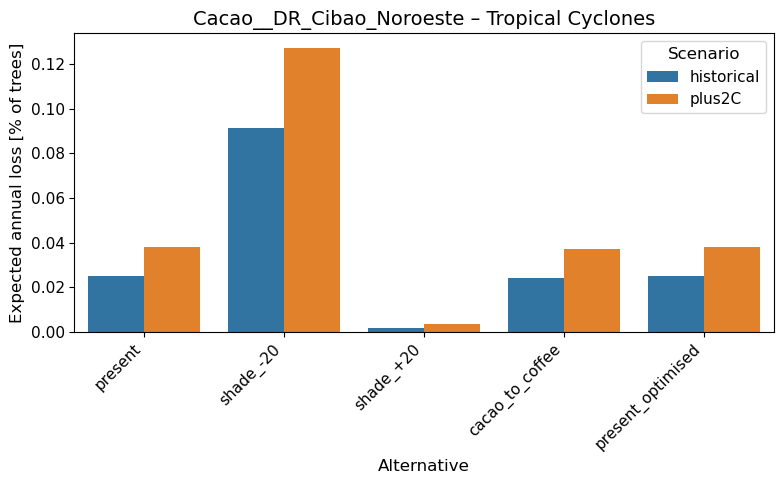

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__DR_Cibao_Noroeste_TC_barplot.png


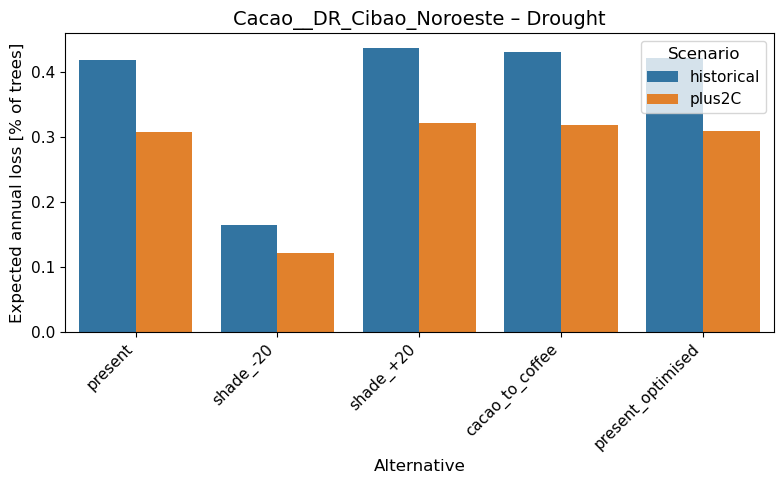

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__DR_Cibao_Noroeste_DR_barplot.png


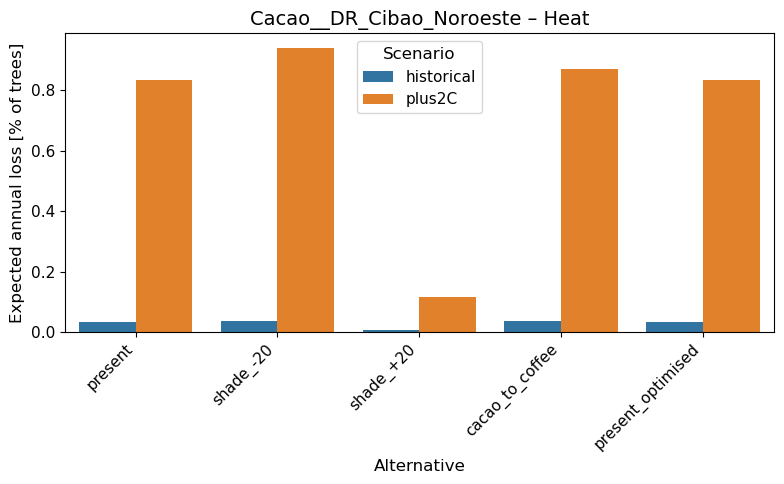

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__DR_Cibao_Noroeste_TM_barplot.png


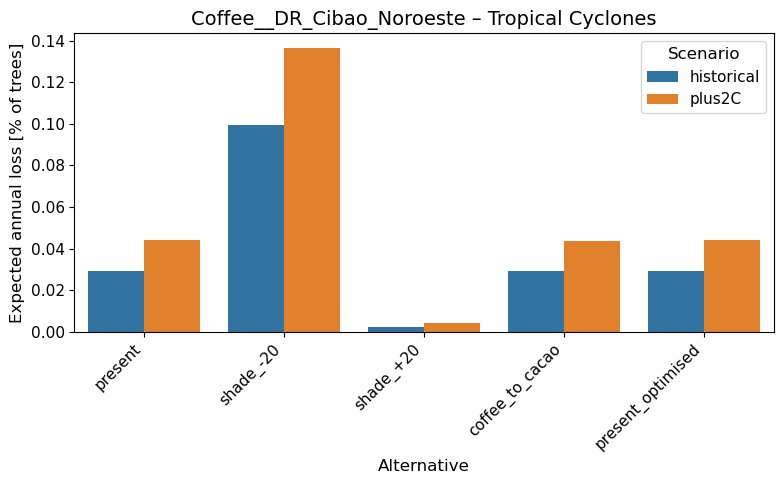

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__DR_Cibao_Noroeste_TC_barplot.png


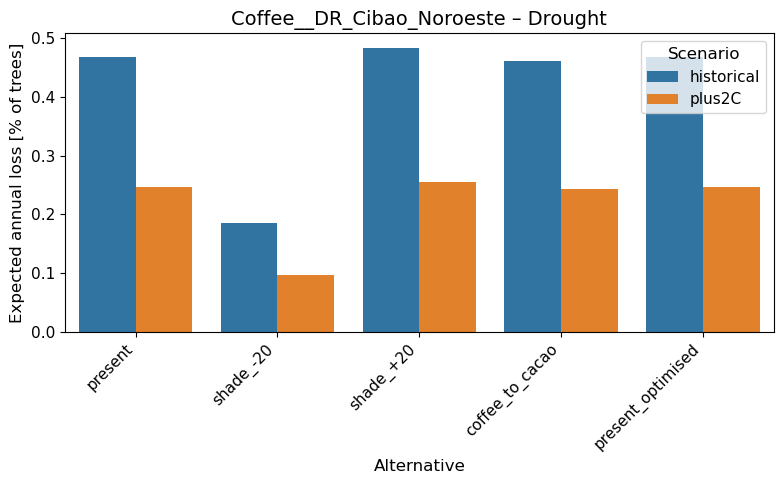

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__DR_Cibao_Noroeste_DR_barplot.png


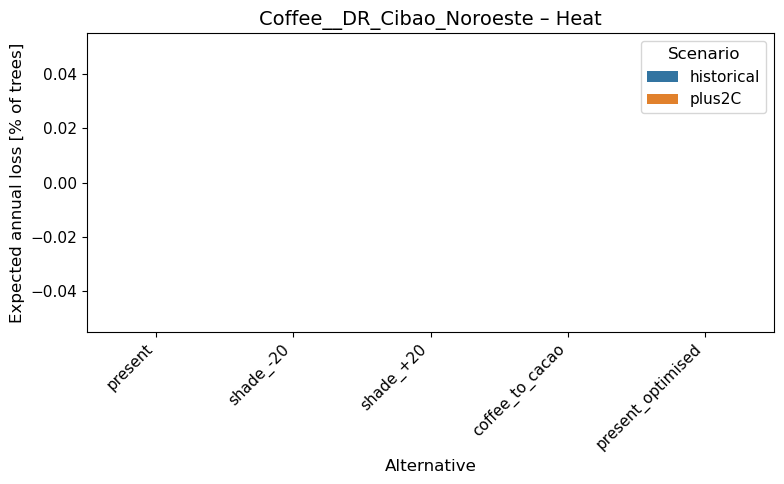

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__DR_Cibao_Noroeste_TM_barplot.png


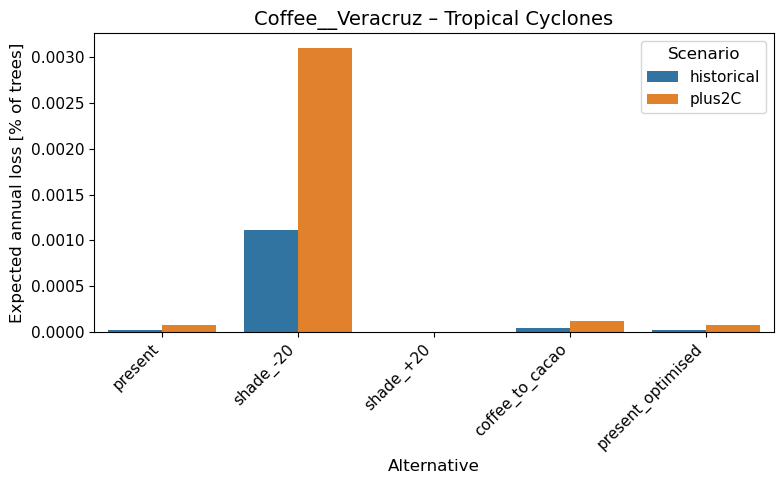

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__Veracruz_TC_barplot.png


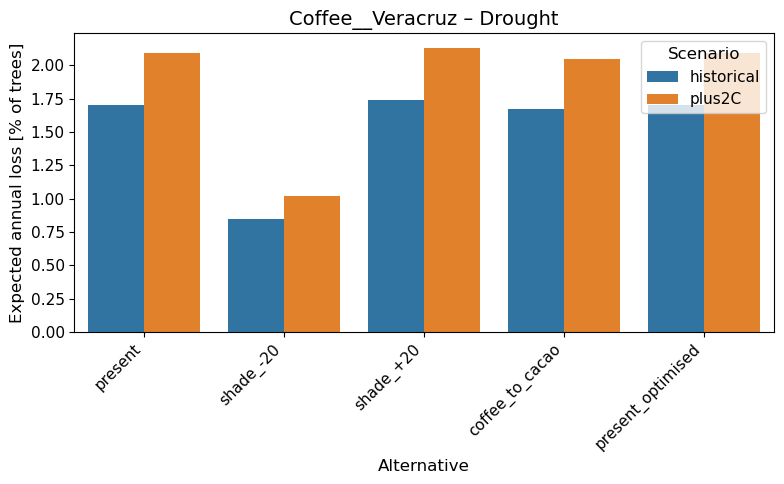

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__Veracruz_DR_barplot.png


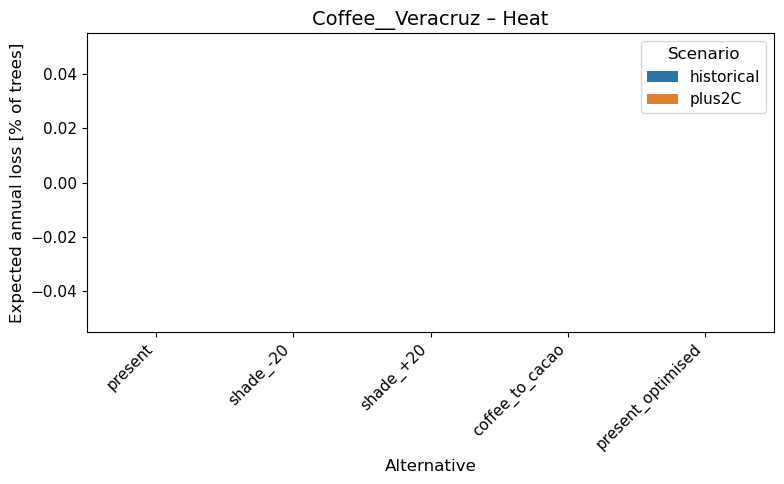

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__Veracruz_TM_barplot.png


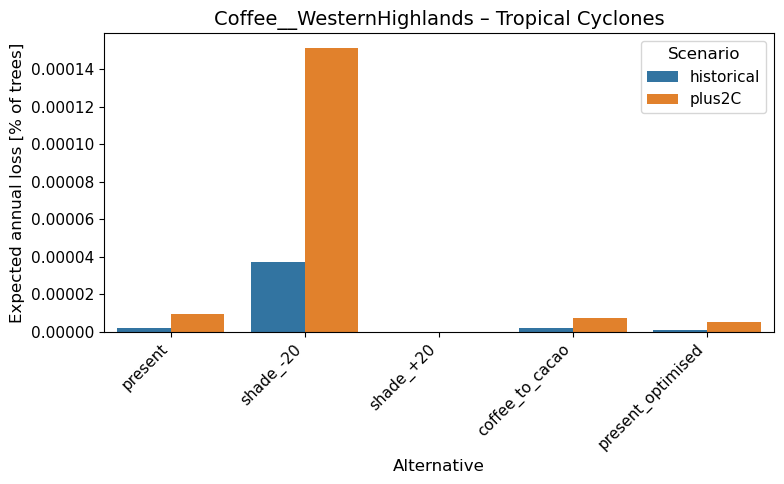

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__WesternHighlands_TC_barplot.png


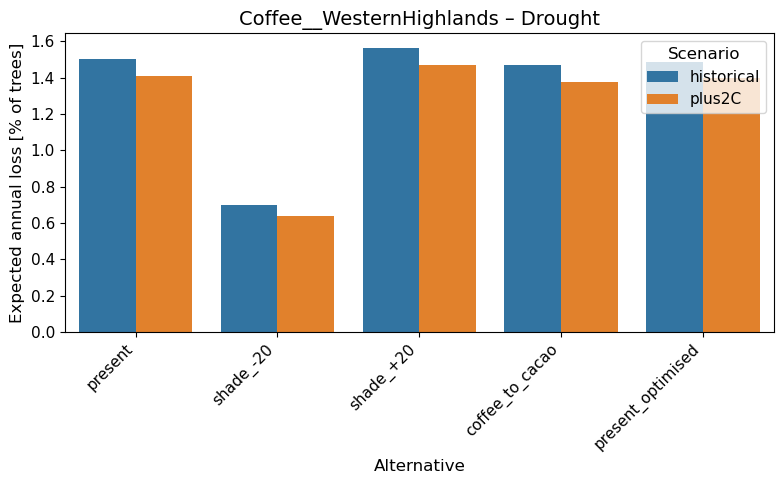

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__WesternHighlands_DR_barplot.png


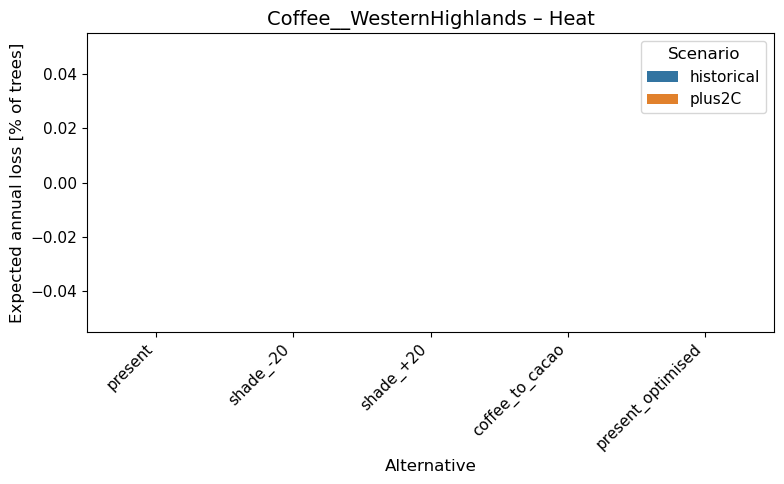

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__WesternHighlands_TM_barplot.png


In [69]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

summary_records = []

# === Build summary dataframe ===
for system_name, alternatives in impact_results.items():
    for alt_name, haz_dict in alternatives.items():
        total_trees = exposures[system_name][alt_name].gdf.value.sum()

        for scenario, hazs in haz_dict.items():
            if scenario not in ["historical", "plus2C"]:  # 🚫 skip +4 °C etc.
                continue
            for haz_code, impact in hazs.items():
                try:
                    eai = impact.aai_agg  # Expected Annual Impact
                    perc_loss = (eai / total_trees) * 100

                    summary_records.append({
                        "System": system_name,
                        "Alternative": alt_name,
                        "Scenario": scenario,
                        "Hazard": haz_code,
                        "PercLoss": perc_loss
                    })
                except Exception as e:
                    print(f"⚠️ Could not compute for {system_name} – {alt_name} – {haz_code}: {e}")
                    continue

df_summary = pd.DataFrame(summary_records)

# === Output directory ===
out_dir = os.path.join(FIGURES_DIR, "barplots")
os.makedirs(out_dir, exist_ok=True)

# === Plot per system × hazard ===
for system_name in df_summary["System"].unique():
    df_sys = df_summary[df_summary["System"] == system_name]

    for haz_code, haz_label in hazards_to_plot.items():
        df_haz = df_sys[df_sys["Hazard"] == haz_code]

        if df_haz.empty:
            continue

        plt.figure(figsize=(8, 5))
        sns.barplot(
            data=df_haz,
            x="Alternative", y="PercLoss", hue="Scenario",
            hue_order=["historical", "plus2C"],   # ✅ enforce order
            palette={"historical": "tab:blue", "plus2C": "tab:orange"}
        )
        plt.ylabel("Expected annual loss [% of trees]")
        plt.title(f"{system_name} – {haz_label}")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Scenario")
        plt.tight_layout()

        # Save instead of show
        fname = f"{system_name}_{haz_code}_barplot.png"
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"💾 Saved: {fpath}")


In [38]:
df_summary

System        Alternative    Scenario  Hazard  PercLoss
0         Cacao__AltaVerapaz            present      plus2C     NaN  1.221813
1         Cacao__AltaVerapaz            present      plus2C     NaN  0.008515
2         Cacao__AltaVerapaz            present  historical     NaN  1.264876
3         Cacao__AltaVerapaz          shade_-20      plus2C     NaN  0.572999
4         Cacao__AltaVerapaz          shade_-20      plus2C     NaN  0.023286
..                       ...                ...         ...     ...       ...
70  Coffee__WesternHighlands    coffee_to_cacao      plus2C     NaN  0.000008
71  Coffee__WesternHighlands    coffee_to_cacao  historical     NaN  1.467294
72  Coffee__WesternHighlands  present_optimised      plus2C     NaN  1.395221
73  Coffee__WesternHighlands  present_optimised      plus2C     NaN  0.000005
74  Coffee__WesternHighlands  present_optimised  historical     NaN  1.486587

[75 rows x 5 columns]

Unique hazard codes in df_summary: ['DR' 'TM' 'TC']


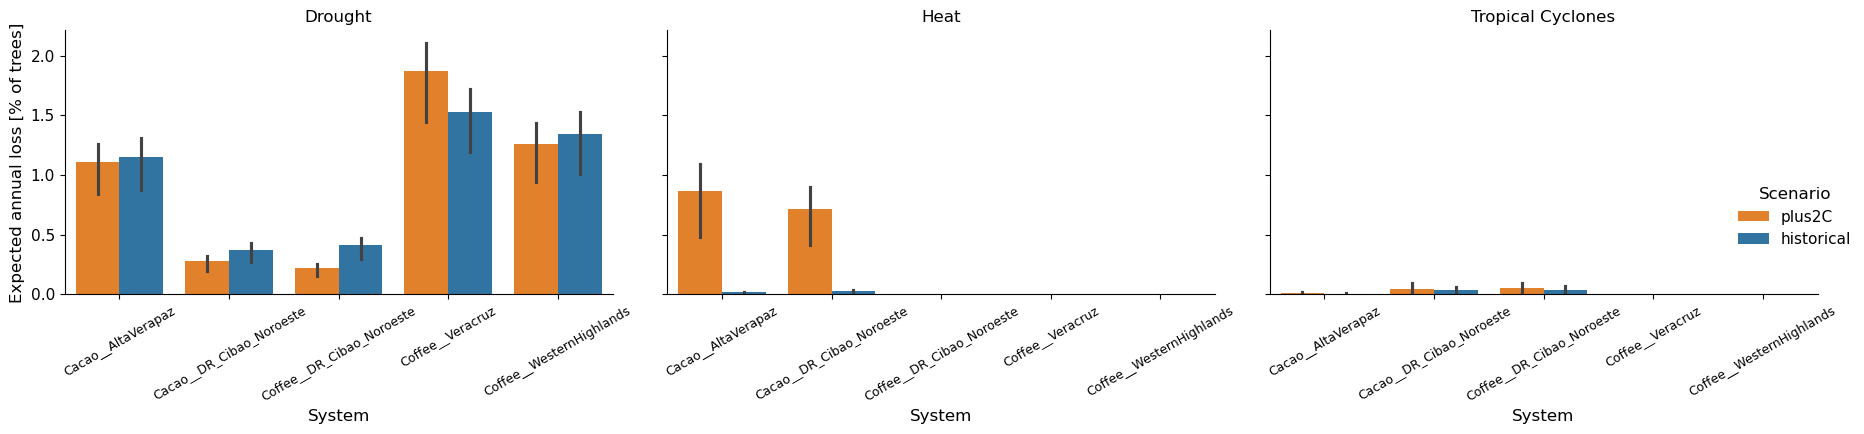

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Inspect hazard codes in df_summary
print("Unique hazard codes in df_summary:", df_summary["Hazard"].unique())

# Replace codes with labels, keep unmapped as-is
df_summary["Hazard"] = df_summary["Hazard"].replace(hazards_to_plot)

# Drop any rows where Hazard is still missing
df_plot = df_summary.dropna(subset=["Hazard"]).copy()

# === Plot: one panel per hazard ===
g = sns.catplot(
    data=df_plot,
    x="System", y="PercLoss",
    hue="Scenario", col="Hazard",
    kind="bar",
    palette={"historical": "tab:blue", "plus2C": "tab:orange"},
    dodge=True,
    col_wrap=3, height=4.5, aspect=1.3
)

g.set_titles("{col_name}")
g.set_axis_labels("System", "Expected annual loss [% of trees]")

# Rotate x-axis labels for readability
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30, labelsize=9)

plt.tight_layout()
plt.show()


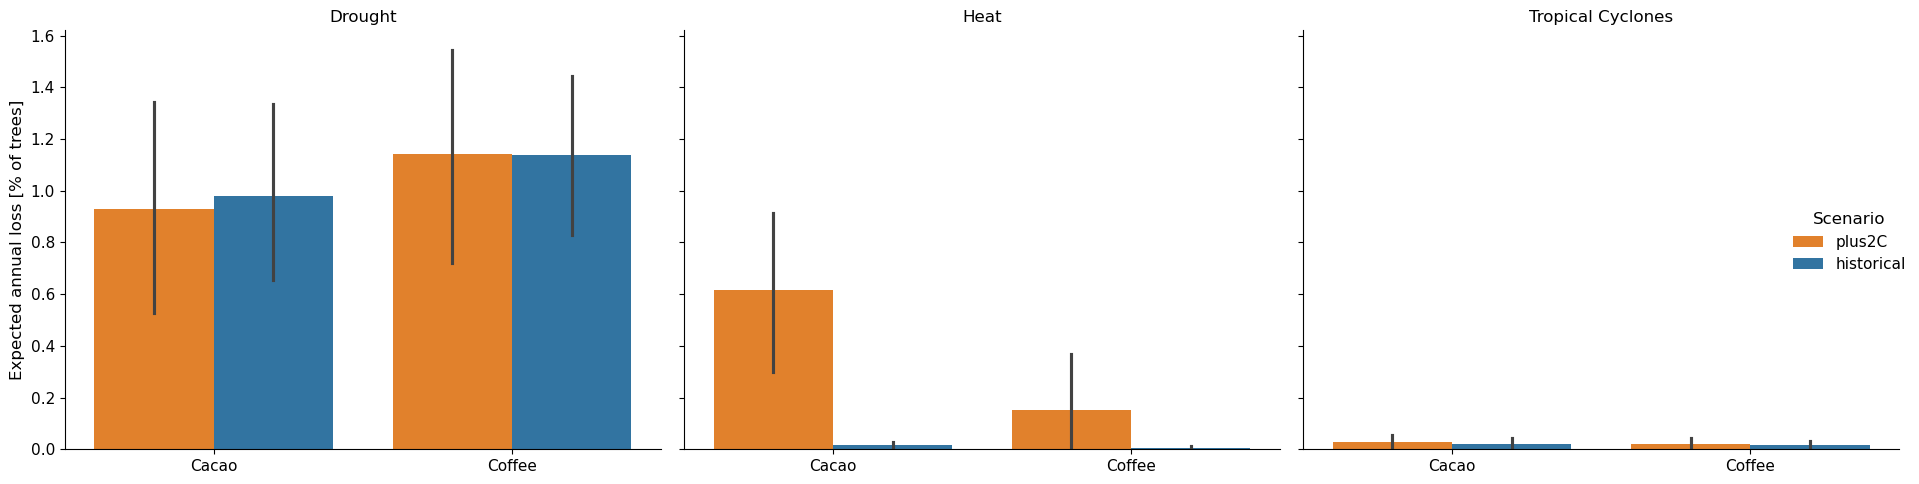

In [71]:
MAIN_CROPS = {"Coffea arabica": "Coffee", "Theobroma cacao": "Cacao"}

summary_records = []

for system_name, alternatives in impact_results.items():
    for alt_name, haz_dict in alternatives.items():
        gdf_exp = exposures[system_name][alt_name].gdf

        for crop_code, crop_label in MAIN_CROPS.items():
            total_trees = gdf_exp.loc[gdf_exp["Scientific name"] == crop_code, "value"].sum()
            if total_trees == 0:
                continue

            for scenario, hazs in haz_dict.items():
                if scenario not in ["historical", "plus2C"]:
                    continue

                for haz_code, impact in hazs.items():
                    try:
                        eai = impact.aai_agg
                        perc_loss = (eai / total_trees) * 100

                        summary_records.append({
                            "Crop": crop_label,
                            "Scenario": scenario,
                            "Hazard": haz_code,
                            "PercLoss": perc_loss
                        })
                    except Exception:
                        continue

df_crops = pd.DataFrame(summary_records)

# Map hazard codes to labels
df_crops["Hazard"] = df_crops["Hazard"].replace(hazards_to_plot)

# === Plot coffee vs cacao ===
g = sns.catplot(
    data=df_crops,
    x="Crop", y="PercLoss",
    hue="Scenario", col="Hazard",
    kind="bar",
    palette={"historical": "tab:blue", "plus2C": "tab:orange"},
    dodge=True,
    height=5, aspect=1.2
)

g.set_titles("{col_name}")
g.set_axis_labels("", "Expected annual loss [% of trees]")

plt.tight_layout()
plt.show()
